In [ ]:
%pip install opencv-python

In [ ]:
%pip install torchio


In [10]:
# %% [markdown]
# # CapsViT-GRAIL: A Novel AI Architecture for Early-Stage Lung Cancer Detection
#
# **A Research Notebook Prototype (with User-Provided Preprocessing)**
#
# **Abstract:** ... (Abstract remains the same) ...
#
# **Keywords:** ... (Keywords remain the same) ...

# %% [markdown]
# ---
# ## 📝 **Notebook Setup and Configuration**
# ---

# %%
import os
import shutil
import time
import random
import warnings
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

# DICOM and NIfTI processing
import pydicom
import SimpleITK as sitk # For the original resample_volume, if kept as an alternative

# Image processing and augmentation
import scipy.ndimage
import scipy.ndimage as ndi # For user's get_segmented_lungs
from skimage.segmentation import clear_border
from skimage.measure import label as skimage_label, regionprops # For user's get_segmented_lungs
from skimage.morphology import disk, binary_closing # For user's get_segmented_lungs
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast

# TorchIO for 3D augmentations
import torchio as tio

# Einops for readable tensor operations
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Torch Geometric for GNNs
try:
    import torch_geometric.nn as pyg_nn
    import torch_geometric.data as pyg_data
    from torch_geometric.utils import to_networkx
    import networkx as nx
except ImportError:
    print("Torch Geometric not fully installed. GNN part might not run.")
    pyg_nn = None
    pyg_data = None

# Scikit-learn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, precision_score,
    recall_score, confusion_matrix, roc_curve
)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuration
CONFIG = {
    "data_dir": r"C:\Users\rouaa\Documents\Final_Pneumatect\Stages", # IMPORTANT: Set your real data path
    "processed_dir": r"C:\Users\rouaa\Documents\Final_Pneumatect\Preprocessed_Data_DSB", # New dir for this prep
    "labels_path": r"C:\Users\rouaa\Documents\Final_Pneumatect\stage1_labels.csv", # IMPORTANT: Set your real labels path
    "num_samples_to_use": 50, # Number of patients to process from your dataset
    
    # Preprocessing parameters for user's functions
    "target_spacing": (1.0, 1.0, 1.0),  # For physical resampling (Z, Y, X) mm
    "norm_hu_min": -1000,               # HU clipping lower bound
    "norm_hu_max": 400,                 # HU clipping upper bound
    "pixel_mean": 0.25, # Example: If HU normalized to [0,1] & then want to center around something else.
                        # Or, if HU range is e.g. -1000 to 400, after normalization it's 0 to 1.
                        # For zero-centering to [-0.5, 0.5], set pixel_mean=0.5 if previous step outputs [0,1]
                        # The value 0.25 is from some public kernels, often derived from dataset stats.
    "perform_zero_centering": True,
    "segmentation_hu_threshold": -320,  # Threshold for get_segmented_lungs

    "volume_size": (128, 128, 128), # Target final PyTorch tensor shape (H, W, D)
                                    # Numpy arrays will be processed as (D, H, W)

    "batch_size_pretrain": 2,       # Adjusted for potentially larger real data
    "batch_size_finetune": 1,       # Start very small for real 3D data due to memory
    "lr_pretrain": 1e-4,
    "lr_finetune": 5e-5,
    "epochs_pretrain": 5,           # Reduced for faster prototype runs
    "epochs_finetune": 10,          # Reduced for faster prototype runs
    "num_workers": 0,
    "model_save_path": "models/",
    "results_path": "results/",
    "use_mixed_precision": True,
    "successfully_processed_ids": [] # Will be populated after preprocessing
}

# Create necessary directories
os.makedirs(CONFIG["processed_dir"], exist_ok=True)
os.makedirs(CONFIG["model_save_path"], exist_ok=True)
os.makedirs(CONFIG["results_path"], exist_ok=True)

print(f"Configuration loaded. Data will be read from: {CONFIG['data_dir']}")
print(f"Processed data will be saved to: {CONFIG['processed_dir']}")


Torch Geometric not fully installed. GNN part might not run.
Using device: cpu
Configuration loaded. Data will be read from: C:\Users\rouaa\Documents\Final_Pneumatect\Stages
Processed data will be saved to: C:\Users\rouaa\Documents\Final_Pneumatect\Preprocessed_Data_DSB


In [ ]:

# ---
# ## 🧩 **PART 1: Dataset Preparation (with User-Provided Functions)**
# ---
#
# This section uses real, locally stored DSB2017 data and user-provided preprocessing functions.
# **Crucial Assumption:** `load_scan_dicom` must return images where pixel values represent Hounsfield Units (HU),
# with values like air around -1000 HU, for the `get_segmented_lungs` function to work as intended.

# %% [markdown]
# ### 1.1 DICOM Loading and 3D Volumetric Reconstruction

# %%
def load_scan_dicom(patient_id, data_dir):
    """
    Loads a CT scan for a given patient ID from DICOM files.
    Attempts to return a 3D numpy array in Hounsfield Units (HU) and pixel spacing.
    Output: image_3d (D, H, W) as np.float32, spacing (Z, Y, X) as np.float32
    """
    scan_path = os.path.join(data_dir, patient_id)
    if not os.path.isdir(scan_path):
        print(f"Error: Scan path not found or not a directory: {scan_path}")
        return None, None
        
    dicom_files = [os.path.join(scan_path, s) for s in os.listdir(scan_path) if s.endswith('.dcm')]
    if not dicom_files:
        print(f"Error: No DICOM files found in {scan_path}")
        return None, None
        
    slices_pydicom = []
    for dcm_file in dicom_files:
        try:
            slices_pydicom.append(pydicom.dcmread(dcm_file))
        except Exception as e:
            print(f"Warning: Could not read DICOM file {dcm_file}: {e}")
            continue # Skip problematic file
    
    if not slices_pydicom:
        print(f"Error: No valid DICOM slices could be read for {patient_id}")
        return None, None

    # Sort slices
    try:
        slices_pydicom.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except AttributeError:
        # print(f"Warning: ImagePositionPatient not found for {patient_id}, attempting to sort by InstanceNumber.")
        try:
            slices_pydicom.sort(key=lambda x: int(x.InstanceNumber))
        except AttributeError:
            print(f"Error: Cannot sort slices for {patient_id} by InstanceNumber either.")
            return None, None
    
    # Extract pixel data and convert to HU
    image_data_hu = []
    for s_idx, s in enumerate(slices_pydicom):
        if not (hasattr(s, 'PixelData') and hasattr(s, 'Rows') and hasattr(s, 'Columns')):
            print(f"Warning: Slice {s_idx} in {patient_id} missing critical DICOM tags (PixelData/Rows/Columns). Skipping slice.")
            continue
        try:
            # pydicom's pixel_array should apply RescaleSlope and RescaleIntercept
            pixel_array_hu = s.pixel_array.astype(np.float32)
            image_data_hu.append(pixel_array_hu)
        except Exception as e:
            print(f"Warning: s.pixel_array failed for slice {s_idx} in {patient_id}: {e}. Attempting manual HU conversion.")
            try:
                # Determine expected raw pixel type
                if not hasattr(s, 'PixelRepresentation') or not hasattr(s, 'BitsStored'):
                    print(f"  Error: PixelRepresentation or BitsStored missing for manual conversion. Skipping slice {s_idx}.")
                    continue

                dtype_str = 'int' if s.PixelRepresentation == 1 else 'uint'
                dtype_str += str(s.BitsStored)
                raw_pixel_values = np.frombuffer(s.PixelData, dtype=np.dtype(dtype_str)).reshape((s.Rows, s.Columns))
                
                rescale_slope = float(getattr(s, 'RescaleSlope', 1.0))
                rescale_intercept = float(getattr(s, 'RescaleIntercept', 0.0))
                
                pixel_array_hu = raw_pixel_values.astype(np.float32) * rescale_slope + rescale_intercept
                image_data_hu.append(pixel_array_hu)
            except Exception as e_manual:
                print(f"  Error: Manual pixel data parsing/HU conversion also failed for slice {s_idx} in {patient_id}: {e_manual}")
                # Depending on strictness, one might choose to fail the whole scan here
                
    if not image_data_hu:
        print(f"Error: No pixel data successfully converted to HU for {patient_id}")
        return None, None

    try:
        image_3d_hu = np.stack(image_data_hu) # Should be (D, H, W)
    except ValueError as e:
        print(f"Error: Could not stack image slices for {patient_id}. Slices might have different shapes. {e}")
        # Optionally print shapes of slices in image_data_hu for debugging
        # for i, arr in enumerate(image_data_hu): print(f"Slice {i} shape: {arr.shape}")
        return None, None
    
    # Determine spacing
    first_slice = slices_pydicom[0]
    try:
        slice_thickness = float(first_slice.SliceThickness)
    except (AttributeError, ValueError):
        if len(slices_pydicom) > 1:
            try:
                slice_thickness = abs(float(slices_pydicom[1].ImagePositionPatient[2]) - float(first_slice.ImagePositionPatient[2]))
            except (AttributeError, IndexError, ValueError):
                slice_thickness = 2.5 # Fallback - risky
                # print(f"Warning: Cannot infer SliceThickness for {patient_id}. Using default {slice_thickness}mm - MAY BE INCORRECT.")
        else:
            slice_thickness = 2.5 # Fallback - risky
            # print(f"Warning: Only one slice for {patient_id}. Using default {slice_thickness}mm - MAY BE INCORRECT.")
            
    try:
        pixel_spacing_xy = [float(ps) for ps in first_slice.PixelSpacing]
    except (AttributeError, ValueError, TypeError):
        pixel_spacing_xy = [0.7, 0.7] # Fallback - risky
        # print(f"Warning: PixelSpacing not found/invalid for {patient_id}. Using default {pixel_spacing_xy} - MAY BE INCORRECT.")
        
    spacing = np.array([slice_thickness] + pixel_spacing_xy, dtype=np.float32) # (Z, Y, X)
    
    return image_3d_hu, spacing



In [ ]:
# %% [markdown]
# ### 1.2 User-Provided Preprocessing Functions

# %%
def resample_user(image, original_spacing, new_spacing): # Renamed to avoid conflict if old resample exists
    """Resamples image to new_spacing using scipy.ndimage.zoom."""
    try:
        resize_factor = np.array(original_spacing) / np.array(new_spacing)
        new_real_shape = image.shape * resize_factor
        new_shape = np.round(new_real_shape)
        
        # Ensure new_shape components are positive and non-zero
        new_shape[new_shape < 1] = 1 
        
        real_resize_factor = new_shape / np.array(image.shape)
        # Calculate the spacing that was actually achieved
        actual_new_spacing = np.array(original_spacing) / real_resize_factor
        
        # Scipy.ndimage.zoom expects zoom factors for each axis
        resampled_image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest', order=1) # order=1 for bilinear
        return resampled_image, actual_new_spacing
    except Exception as e:
        print(f"Error during resampling: {e}")
        return None, None

def get_segmented_lungs_user(im_slice, hu_threshold=-320): # Renamed
    """Segments lungs from a 2D slice. Expects im_slice in HU."""
    if im_slice.ndim != 2:
        # print("Warning: get_segmented_lungs_user received non-2D slice, returning as is.")
        return im_slice # Should not happen if called correctly
    
    # Step 1: Thresholding
    binary = im_slice < hu_threshold
    if np.sum(binary) == 0: # No pixels below threshold
        # print(f"Debug seg: No pixels < {hu_threshold}. Min HU: {im_slice.min()}")
        # Return a black mask which will lead to background fill
        return np.full(im_slice.shape, (CONFIG["norm_hu_min"] - 1), dtype=im_slice.dtype)


    # Step 2: Clear border
    cleared = clear_border(binary)
    if np.sum(cleared) == 0:
        # print("Debug seg: clear_border removed everything.")
        return np.full(im_slice.shape, (CONFIG["norm_hu_min"] - 1), dtype=im_slice.dtype)

    # Step 3: Label and select largest regions
    label_image = skimage_label(cleared)
    regions = regionprops(label_image)
    areas = [r.area for r in regions]
    
    final_mask_binary = np.zeros_like(binary, dtype=bool)

    if areas: # If any regions were found
        areas.sort()
        # Heuristic: take up to two largest regions
        area_threshold = areas[-2] if len(areas) >= 2 else areas[-1]
        
        selected_region_count = 0
        for region in regions:
            if region.area >= area_threshold: # Keep this region and potentially one more if it's the second largest
                final_mask_binary[label_image == region.label] = True
                selected_region_count +=1
                if selected_region_count >=2 : # Allow up to two largest distinct regions
                    break 
        if selected_region_count == 0 and len(areas) > 0: # Fallback if area_threshold logic somehow failed but regions exist
            largest_region_label = regions[areas.index(areas[-1])].label
            final_mask_binary[label_image == largest_region_label] = True


    if np.sum(final_mask_binary) == 0:
        # print("Debug seg: No regions selected or thresholding failed.")
        return np.full(im_slice.shape, (CONFIG["norm_hu_min"] - 1), dtype=im_slice.dtype)

    # Step 4: Morphological operations
    selem_close = disk(2) # Small closing
    closed_binary = binary_closing(final_mask_binary, selem_close)
    
    selem_dilate = disk(5) # Dilation to ensure coverage
    dilated_mask = ndi.binary_dilation(closed_binary, structure=selem_dilate)

    # Step 5: Apply mask
    # Value for pixels outside the lungs (background)
    background_val = CONFIG["norm_hu_min"] - 1 # Slightly less than min HU bound
    segmented_slice = im_slice.copy() # Important to work on a copy
    segmented_slice[dilated_mask == 0] = background_val # Pixels not in mask get background_val
    
    return segmented_slice

def normalize_hu_user(image, clip_bounds=(-1000, 400)): # Renamed
    """Clips HU to clip_bounds and normalizes to [0, 1]."""
    min_bound, max_bound = clip_bounds
    image = np.clip(image, min_bound, max_bound)
    # Avoid division by zero if min_bound == max_bound (though unlikely for HU)
    denominator = (max_bound - min_bound)
    if denominator == 0: denominator = 1e-6 
    image = (image - min_bound) / denominator
    return image.astype(np.float32)

def zero_center_user(image, pixel_mean=0.25): # Renamed
    """Subtracts pixel_mean from the image."""
    image = image - pixel_mean
    return image.astype(np.float32)

def resize_scan_to_target_user(image, target_shape_dhw): # Renamed
    """Resizes 3D image to target_shape_dhw (D,H,W) using zoom and correcting with crop/pad."""
    if image.shape == target_shape_dhw:
        return image.astype(np.float32)

    resize_factor = np.array(target_shape_dhw, dtype=float) / np.array(image.shape, dtype=float)
    
    try:
        # Use bi-linear interpolation (order=1) for resizing continuous values
        resized_image = scipy.ndimage.zoom(image, resize_factor, order=1, mode='nearest')
        
        # Correction if zoom doesn't hit the exact shape due to rounding
        if resized_image.shape != target_shape_dhw:
            current_shape = np.array(resized_image.shape)
            target_shape_arr = np.array(target_shape_dhw)
            
            diff = target_shape_arr - current_shape
            
            pads = np.maximum(diff, 0)
            crops = np.maximum(-diff, 0)
            
            pad_width = []
            for p_ax in pads:
                p1 = p_ax // 2
                p2 = p_ax - p1
                pad_width.append((p1,p2))
            
            if np.any(pads > 0):
                resized_image = np.pad(resized_image, pad_width, mode='edge')

            crop_slices = []
            for c_ax, s_ax_current_padded in zip(crops, resized_image.shape):
                c1 = c_ax // 2
                c2 = c_ax - c1
                crop_slices.append(slice(c1, s_ax_current_padded - c2))

            if np.any(crops > 0):
                 resized_image = resized_image[tuple(crop_slices)]
        
        if resized_image.shape != target_shape_dhw:
            # Final hard crop/pad if still mismatched (e.g. off-by-one)
            # This is a fallback, the above logic should ideally handle it.
            # print(f"Warning: Resize shape mismatch {resized_image.shape} vs {target_shape_dhw}. Applying hard crop/pad.")
            final_corrected_image = np.zeros(target_shape_dhw, dtype=image.dtype)
            
            src_slices = tuple(slice(min(s_orig, s_targ)) for s_orig, s_targ in zip(resized_image.shape, target_shape_dhw))
            trg_slices = tuple(slice(min(s_orig, s_targ)) for s_orig, s_targ in zip(resized_image.shape, target_shape_dhw))
            
            final_corrected_image[trg_slices] = resized_image[src_slices]
            resized_image = final_corrected_image

        if resized_image.shape != target_shape_dhw:
             print(f"ERROR: Final resize failed. Shape after correction {resized_image.shape} vs target {target_shape_dhw}")
             return None
             
        return resized_image.astype(np.float32)
    except Exception as e:
        print(f"Error during resize_scan_to_target_user: {e}")
        return None



In [23]:

# ### 1.3 Full Preprocessing Pipeline

# %%
def preprocess_patient_with_user_fns(patient_id, data_dir, processed_dir, config, perform_segmentation=True):
    """Full preprocessing pipeline with enhanced debugging."""
    print(f"\n--- Starting Preprocessing for Patient: {patient_id} ---")
    try:
        # Fetch config params
        target_spacing_xyz = config["target_spacing"]
        clip_bounds_hu = (config["norm_hu_min"], config["norm_hu_max"])
        pixel_mean_val = config.get("pixel_mean", 0.25)
        perform_zero_center = config.get("perform_zero_centering", True)
        seg_hu_thresh = config.get("segmentation_hu_threshold", -320)
        final_scan_shape_dhw = (config["volume_size"][2], config["volume_size"][0], config["volume_size"][1])
        processed_dir_path = config["processed_dir"] # Get processed dir path

        # --- Step 1: Load DICOM ---
        print(f"  1. Loading DICOM...")
        img_3d_hu, original_spacing_xyz = load_scan_dicom(patient_id, data_dir)
        if img_3d_hu is None:
             print(f"  FAIL: load_scan_dicom returned None.")
             return False
        print(f"     Loaded shape: {img_3d_hu.shape}, Spacing: {original_spacing_xyz}, HU range: [{img_3d_hu.min():.1f}, {img_3d_hu.max():.1f}], dtype: {img_3d_hu.dtype}")

        # --- Step 2: Resample ---
        print(f"  2. Resampling to spacing {target_spacing_xyz}...")
        resampled_img_hu, actual_new_spacing = resample_user(img_3d_hu, original_spacing_xyz, new_spacing=target_spacing_xyz)
        if resampled_img_hu is None:
            print(f"  FAIL: resample_user returned None.")
            return False
        print(f"     Resampled shape: {resampled_img_hu.shape}, New spacing: {actual_new_spacing}, HU range: [{resampled_img_hu.min():.1f}, {resampled_img_hu.max():.1f}], dtype: {resampled_img_hu.dtype}")

        # --- Step 3: Segmentation ---
        img_to_normalize = resampled_img_hu.copy() # Start with resampled
        if perform_segmentation:
            print(f"  3. Segmenting (Threshold: {seg_hu_thresh} HU)...")
            segmented_volume_slices = []
            segmentation_failed = False
            for i in range(resampled_img_hu.shape[0]):
                segmented_slice = get_segmented_lungs_user(resampled_img_hu[i, :, :], hu_threshold=seg_hu_thresh)
                # Check if segmentation function returned something valid (not just background)
                if segmented_slice is None: # Should not happen based on current get_segmented_lungs_user, but good check
                    print(f"     FAIL: get_segmented_lungs_user returned None for slice {i}.")
                    segmentation_failed = True
                    break
                segmented_volume_slices.append(segmented_slice)
            
            if not segmentation_failed and segmented_volume_slices:
                img_to_normalize_segmented = np.stack(segmented_volume_slices)
                background_check_val = clip_bounds_hu[0] - 1
                foreground_pixels = np.sum(img_to_normalize_segmented > background_check_val)
                total_pixels = np.prod(img_to_normalize_segmented.shape)
                foreground_ratio = foreground_pixels / total_pixels if total_pixels > 0 else 0
                print(f"     Segmentation output HU range: [{img_to_normalize_segmented.min():.1f}, {img_to_normalize_segmented.max():.1f}], Foreground ratio: {foreground_ratio:.3f}")
                if foreground_ratio > 0.005: # If > 0.5% foreground
                    img_to_normalize = img_to_normalize_segmented
                    print(f"     Segmentation applied.")
                else:
                    print(f"     Warning: Segmentation resulted in <= 0.5% foreground. Using unsegmented volume.")
            elif segmentation_failed:
                 print(f"     FAIL: Segmentation failed for one or more slices. Using unsegmented volume.")
            else: # segmented_volume_slices is empty
                 print(f"     FAIL: No slices returned from segmentation loop. Using unsegmented volume.")
        else:
            print(f"  3. Segmentation skipped.")
        # print(f"     Input to Norm shape: {img_to_normalize.shape}, HU range: [{img_to_normalize.min():.1f}, {img_to_normalize.max():.1f}], dtype: {img_to_normalize.dtype}")

        # --- Step 4: Normalize HU ---
        print(f"  4. Normalizing HU to [0,1] (Clip: {clip_bounds_hu})...")
        normalized_img = normalize_hu_user(img_to_normalize, clip_bounds=clip_bounds_hu)
        print(f"     Normalized shape: {normalized_img.shape}, Value range: [{normalized_img.min():.2f}, {normalized_img.max():.2f}], dtype: {normalized_img.dtype}")

        # --- Step 5: Zero-Center ---
        img_to_resize = normalized_img # Default if zero-centering is off
        if perform_zero_center:
            print(f"  5. Zero-Centering (Mean: {pixel_mean_val})...")
            img_to_resize = zero_center_user(normalized_img, pixel_mean=pixel_mean_val)
            print(f"     Zero-Centered shape: {img_to_resize.shape}, Value range: [{img_to_resize.min():.2f}, {img_to_resize.max():.2f}], dtype: {img_to_resize.dtype}")
        else:
             print(f"  5. Zero-Centering skipped.")

        # --- Step 6: Resize to Target Shape ---
        print(f"  6. Resizing to target shape {final_scan_shape_dhw}...")
        final_volume = resize_scan_to_target_user(img_to_resize, target_shape_dhw=final_scan_shape_dhw)
        if final_volume is None:
            print(f"  FAIL: resize_scan_to_target_user returned None.")
            return False
        print(f"     Final shape: {final_volume.shape}, Value range: [{final_volume.min():.2f}, {final_volume.max():.2f}], dtype: {final_volume.dtype}")

        # --- Step 7: Save ---
        print(f"  7. Saving to .npy file...")
        save_path = os.path.join(processed_dir_path, f"{patient_id}.npy")
        np.save(save_path, final_volume)
        print(f"     Successfully saved: {save_path}")
        print(f"--- Finished Preprocessing for Patient: {patient_id} (Success) ---")
        return True # Explicitly return True on success

    except Exception as e:
        print(f"!!!!!!!!! ERROR during full preprocessing for patient {patient_id} !!!!!!!!!")
        import traceback
        print("Traceback:")
        traceback.print_exc()
        print(f"!!!!!!!!! End Error for {patient_id} !!!!!!!!!")
        print(f"--- Finished Preprocessing for Patient: {patient_id} (Failure) ---")
        return False # Return False if any exception occurred in the try block

In [21]:
# Just before the loop in Part 1.4
print(f"Attempting to process {len(selected_patient_ids_for_processing)} patient IDs:")
print(selected_patient_ids_for_processing) # Print the list of IDs


Attempting to process 50 patient IDs:
['1e62be2c3b6430b78ce31a8f023531ac', '2eb8aedb5274414e05041b7be65db3e3', '0b20184e0cd497028bdd155d9fb42dc9', '1be4cf2de84adac4de0e090c9a15461c', '2bb5f7e8f10e1e39b7f81b5aa98676ea', '1cf8e778167d20bf769669b4be96592b', '0d06d764d3c07572074d468b4cff954f', '0a38e7597ca26f9374f8ea2770ba870d', '2d596b6ead89ab35577fe625a9a17cbb', '1ddb5d17d9db61c8ea0fd58d00df05ef', '0ee336c585bf7eb1011df476891c5102', '2a6433cf347f7bd52ab796f083003832', '0fe9dd36f4dece7f4ec017433c4d4a50', '1e0f8048728717064645cb758eb89279', '2c06f5c66f3c79515b7712605dea4400', '2d8152c603e6c49593578bde8e388860', '0a0c32c9e08cc2ea76a71649de56be6d', '2b89691a0744504491ef91d711d94918', '2d977650e6388d2c45825a77e94437a2', '2b0ea2696c8a02af5ac22f142be28e17', '0acbebb8d463b4b9ca88cf38431aac69', '0fe244f21893c45fbb877f54d008518b', '0d2fcf787026fece4e57be167d079383', '1fb4887efd403cd9c0f6970fc8b679b5', '2ed8eb4430bf40f5405495a5ec22a76d', '2f4645c27f9806daffe7e9d013b4b7eb', '2fa939efbc3e1c2bc57ba5a9

Loaded labels from C:\Users\rouaa\Documents\Final_Pneumatect\stage1_labels.csv, shape: (1595, 2)
Found 98 patients with both images and labels.
Selected 50 patients for this run.

--- Testing DICOM load for one real patient: 1e33cb12436a64853c1ae9e918633e05 ---
  Loaded 3D image shape: (216, 512, 512), Spacing: [1.5       0.5488281 0.5488281]
  HU range: min=0, max=4095, mean=542


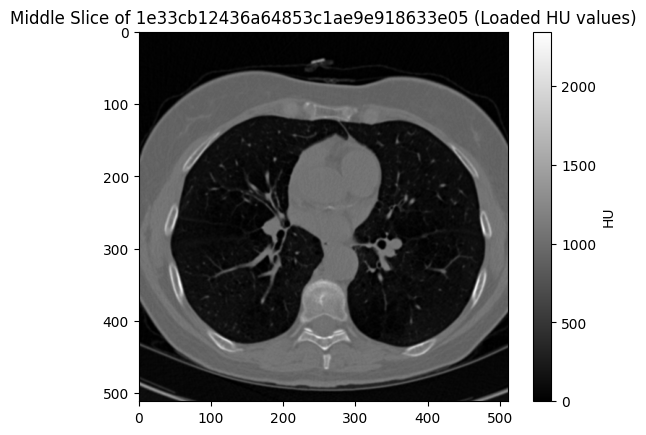

Exception ignored in: <function tqdm.__del__ at 0x000002602E7013A0>
Traceback (most recent call last):
  File "c:\Users\rouaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\rouaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


--- End DICOM load test ---

Cleaning old processed files for 50 selected patients (if any exist)...
  Removed 3 old .npy files.

--- Starting preprocessing loop for 50 patients ---
Segmentation during preprocessing is ENABLED
Consider installing tqdm (`pip install tqdm`) for a progress bar.

--- Starting Preprocessing for Patient: 1e33cb12436a64853c1ae9e918633e05 ---
  1. Loading DICOM...
     Loaded shape: (216, 512, 512), Spacing: [1.5       0.5488281 0.5488281], HU range: [0.0, 4095.0], dtype: float32
  2. Resampling to spacing (1.0, 1.0, 1.0)...
     Resampled shape: (324, 281, 281), New spacing: [1. 1. 1.], HU range: [0.0, 4092.0], dtype: float32
  3. Segmenting (Threshold: -320 HU)...
     Segmentation output HU range: [-1001.0, -1001.0], Foreground ratio: 0.000
  4. Normalizing HU to [0,1] (Clip: (-1000, 400))...
     Normalized shape: (324, 281, 281), Value range: [0.71, 1.00], dtype: float32
  5. Zero-Centering (Mean: 0.25)...
     Zero-Centered shape: (324, 281, 281), Value 

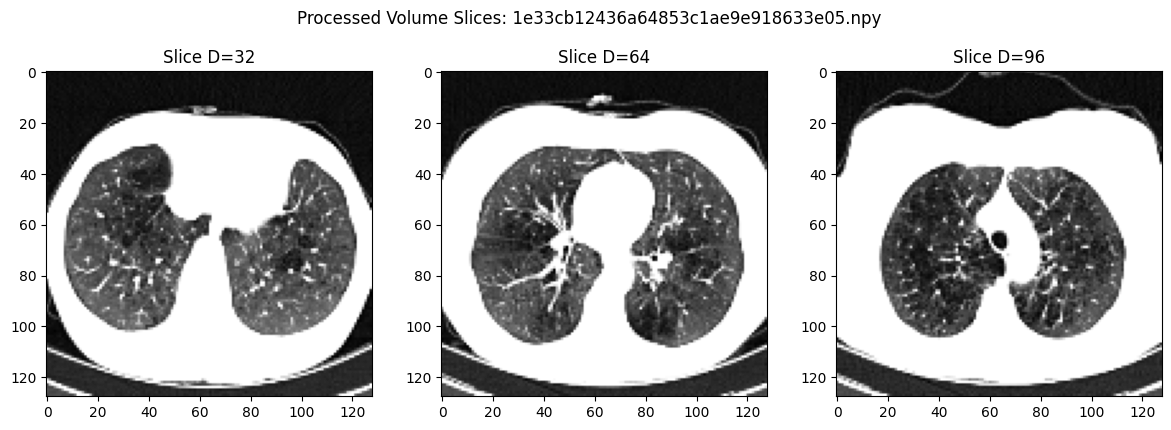

In [24]:
# %% [markdown]
# ### 1.4 Data Loading and Preprocessing Execution

# %%
# Load real patient IDs from disk and filter by labels
all_patient_ids_on_disk = []
if os.path.exists(CONFIG["data_dir"]) and os.path.isdir(CONFIG["data_dir"]):
    all_patient_ids_on_disk = [pid for pid in os.listdir(CONFIG["data_dir"]) if os.path.isdir(os.path.join(CONFIG["data_dir"], pid))]
else:
    # Use f-string for cleaner error message
    raise FileNotFoundError(f"Real data directory not found: {CONFIG['data_dir']}. Please set correctly in CONFIG.")

labels_df_all = pd.DataFrame()
if os.path.exists(CONFIG["labels_path"]):
    labels_df_all = pd.read_csv(CONFIG["labels_path"])
    print(f"Loaded labels from {CONFIG['labels_path']}, shape: {labels_df_all.shape}")
else:
    raise FileNotFoundError(f"Real labels file not found: {CONFIG['labels_path']}. Please set correctly in CONFIG.")

selected_patient_ids_for_processing = []
if not labels_df_all.empty and all_patient_ids_on_disk:
    # Ensure 'id' column exists in labels_df_all
    if 'id' not in labels_df_all.columns:
        raise ValueError("Labels DataFrame must contain an 'id' column.")
        
    labeled_ids_on_disk = [pid for pid in all_patient_ids_on_disk if pid in labels_df_all['id'].values]
    print(f"Found {len(labeled_ids_on_disk)} patients with both images and labels.")

    num_to_use = CONFIG["num_samples_to_use"]
    if not labeled_ids_on_disk:
        print("ERROR: No patients found with both images in data_dir and entries in labels_path.")
    elif len(labeled_ids_on_disk) < num_to_use:
        print(f"Warning: Fewer than {num_to_use} labeled patients available ({len(labeled_ids_on_disk)}). Using all available.")
        selected_patient_ids_for_processing = labeled_ids_on_disk
    else:
        random.shuffle(labeled_ids_on_disk)
        selected_patient_ids_for_processing = labeled_ids_on_disk[:num_to_use]
    print(f"Selected {len(selected_patient_ids_for_processing)} patients for this run.")
else:
    if labels_df_all.empty: print("Labels DataFrame is empty. Cannot select patients.")
    if not all_patient_ids_on_disk: print("No patient image folders found on disk. Cannot select patients.")

# --- Test loading one real scan (Optional but recommended) ---
test_img_3d_hu = None
if selected_patient_ids_for_processing:
    test_patient_id = selected_patient_ids_for_processing[0]
    print(f"\n--- Testing DICOM load for one real patient: {test_patient_id} ---")
    test_img_3d_hu, test_spacing_xyz = load_scan_dicom(test_patient_id, CONFIG["data_dir"])
    if test_img_3d_hu is not None:
        print(f"  Loaded 3D image shape: {test_img_3d_hu.shape}, Spacing: {test_spacing_xyz}")
        # Check HU range - this is critical for segmentation threshold!
        print(f"  HU range: min={test_img_3d_hu.min():.0f}, max={test_img_3d_hu.max():.0f}, mean={test_img_3d_hu.mean():.0f}")
        # Plot middle slice
        plt.imshow(test_img_3d_hu[test_img_3d_hu.shape[0] // 2], cmap='gray')
        plt.title(f"Middle Slice of {test_patient_id} (Loaded HU values)")
        plt.colorbar(label="HU")
        plt.show()
    else:
        print(f"  Failed to load scan for {test_patient_id}. Preprocessing for this ID will likely fail.")
    print(f"--- End DICOM load test ---")
else:
    print("No patients selected for processing. Skipping DICOM load test.")


# --- Clean previously processed files ---
print(f"\nCleaning old processed files for {len(selected_patient_ids_for_processing)} selected patients (if any exist)...")
cleaned_count = 0
for patient_id in selected_patient_ids_for_processing:
    old_file = os.path.join(CONFIG["processed_dir"], f"{patient_id}.npy")
    if os.path.exists(old_file):
        try:
            os.remove(old_file)
            cleaned_count += 1
        except Exception as e:
            print(f"Warning: Could not remove old file {old_file}: {e}")
if cleaned_count > 0: print(f"  Removed {cleaned_count} old .npy files.")

# --- Execute preprocessing loop ---
# Initialize the list in CONFIG before the loop
CONFIG["successfully_processed_ids"] = []
temp_successfully_processed_ids = [] # Use a temporary list to avoid modifying CONFIG inside loop iterations

if selected_patient_ids_for_processing:
    print(f"\n--- Starting preprocessing loop for {len(selected_patient_ids_for_processing)} patients ---")
    processed_count = 0
    # Decide whether to perform segmentation (can be set based on earlier tests)
    # Set perform_segmentation=False if load_scan_dicom doesn't produce correct HU range
    SEGMENTATION_ENABLED = True 
    print(f"Segmentation during preprocessing is {'ENABLED' if SEGMENTATION_ENABLED else 'DISABLED'}")

    # Use tqdm for progress bar if available
    try:
        from tqdm.notebook import tqdm
        patient_iterator = tqdm(selected_patient_ids_for_processing, desc="Preprocessing Patients")
    except ImportError:
        patient_iterator = selected_patient_ids_for_processing
        print("Consider installing tqdm (`pip install tqdm`) for a progress bar.")

    for patient_id in patient_iterator:
        # Use the correct function name defined in Part 1.2
        if preprocess_patient_with_user_fns(patient_id, CONFIG["data_dir"], CONFIG["processed_dir"], CONFIG, perform_segmentation=SEGMENTATION_ENABLED):
            processed_count += 1
            temp_successfully_processed_ids.append(patient_id)
        # Error messages should be printed inside preprocess_patient_with_user_fns
    
    # Update CONFIG *after* the loop finishes
    CONFIG["successfully_processed_ids"] = temp_successfully_processed_ids 
    print(f"--- Finished preprocessing loop ---")
    print(f"  Successfully processed: {processed_count}/{len(selected_patient_ids_for_processing)} patients.")
    print(f"  CONFIG['successfully_processed_ids'] updated with {len(CONFIG['successfully_processed_ids'])} IDs.")
else:
    print("No patients selected or available to process. Preprocessing skipped.")
    # Ensure the list in CONFIG is empty if no processing was attempted
    CONFIG["successfully_processed_ids"] = []

# --- [DEBUG CHECK 1] Verify CONFIG immediately after preprocessing ---
print("\n--- [DEBUG CHECK 1] Verifying CONFIG immediately after preprocessing ---")
debug_ids_post_prep = CONFIG.get('successfully_processed_ids', None) # Use None to distinguish missing key vs empty list
if debug_ids_post_prep is None:
     print("  ERROR: 'successfully_processed_ids' key is MISSING from CONFIG!")
elif isinstance(debug_ids_post_prep, list):
    print(f"  Number of successful IDs stored in CONFIG: {len(debug_ids_post_prep)}")
    if len(debug_ids_post_prep) > 0:
        print(f"  First few successful IDs in CONFIG: {debug_ids_post_prep[:5]}")
    elif len(selected_patient_ids_for_processing) > 0:
        print(f"  WARNING: CONFIG['successfully_processed_ids'] is EMPTY, although {len(selected_patient_ids_for_processing)} patients were attempted.")
    else:
        print(f"  CONFIG['successfully_processed_ids'] is correctly EMPTY as no patients were selected.")
else:
    print(f"  ERROR: CONFIG['successfully_processed_ids'] is not a list! Type is {type(debug_ids_post_prep)}")
print("--- End Debug Check 1 ---")


# --- Verify saved files and plot an example ---
processed_npy_files = glob(os.path.join(CONFIG["processed_dir"], "*.npy"))
print(f"\nFound {len(processed_npy_files)} processed .npy files in target directory: {CONFIG['processed_dir']}.")
if processed_npy_files:
    try:
        # Load the first successfully processed file if available, otherwise just the first found file
        example_file_to_load = processed_npy_files[0] # Default
        if CONFIG.get("successfully_processed_ids"):
             first_successful_id = CONFIG["successfully_processed_ids"][0]
             potential_path = os.path.join(CONFIG["processed_dir"], f"{first_successful_id}.npy")
             if os.path.exists(potential_path):
                 example_file_to_load = potential_path
        
        print(f"Loading example processed volume: {os.path.basename(example_file_to_load)}")
        example_processed_volume = np.load(example_file_to_load)
        print(f"  Shape of loaded volume: {example_processed_volume.shape}")
        print(f"  Value range: min={example_processed_volume.min():.2f}, max={example_processed_volume.max():.2f}")
        
        # Plot slices
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Processed Volume Slices: {os.path.basename(example_file_to_load)}", y=1.02)
        slice_idx_1 = example_processed_volume.shape[0] // 4
        slice_idx_2 = example_processed_volume.shape[0] // 2
        slice_idx_3 = (example_processed_volume.shape[0] * 3) // 4
        
        plt.subplot(1,3,1); plt.imshow(example_processed_volume[slice_idx_1], cmap='gray'); plt.title(f"Slice D={slice_idx_1}")
        plt.subplot(1,3,2); plt.imshow(example_processed_volume[slice_idx_2], cmap='gray'); plt.title(f"Slice D={slice_idx_2}")
        plt.subplot(1,3,3); plt.imshow(example_processed_volume[slice_idx_3], cmap='gray'); plt.title(f"Slice D={slice_idx_3}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error loading or plotting example processed volume: {e}")

# %% [markdown]

In [26]:

# ---
# ### 1.5 PyTorch Dataset Class and Splitting
# ---

# %%
class LungCTDataset(Dataset):
    # --- Definition remains the same as you provided ---
    def __init__(self, patient_ids_list, labels_dataframe, processed_data_dir,
                 target_volume_size_hwd, # Expected PyTorch (H,W,D) from CONFIG
                 transform_fn=None, is_pretrain_mode=False):
        self.patient_ids = patient_ids_list
        # Make a copy and set index to avoid modifying original df outside class
        self.labels_df = labels_dataframe.copy().set_index('id') if 'id' in labels_dataframe.columns else pd.DataFrame()
        self.processed_dir = processed_data_dir
        self.transform = transform_fn
        self.numpy_volume_shape_dhw = (target_volume_size_hwd[2], target_volume_size_hwd[0], target_volume_size_hwd[1])
        self.is_pretrain = is_pretrain_mode

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        if idx >= len(self.patient_ids):
             raise IndexError("Index out of bounds") # Safety check

        patient_id = self.patient_ids[idx]
        volume_path = os.path.join(self.processed_dir, f"{patient_id}.npy")
        
        volume_np_arr = None
        load_successful = False
        try:
            volume_np_arr = np.load(volume_path)
            if volume_np_arr.shape != self.numpy_volume_shape_dhw:
                 print(f"Warning: Vol {patient_id} shape {volume_np_arr.shape} != expected {self.numpy_volume_shape_dhw}.")
                 # Add resize/crop/pad fallback here if needed, e.g.,
                 # volume_np_arr = resize_scan_to_target_user(volume_np_arr, self.numpy_volume_shape_dhw)
                 # if volume_np_arr is None: raise ValueError("Fallback resize failed.")
            load_successful = True
        except FileNotFoundError:
            print(f"ERROR [Dataset]: File not found {volume_path}. Preprocessing failed for {patient_id}?")
        except Exception as e:
            print(f"ERROR [Dataset]: Could not load {volume_path}: {e}")

        # If loading failed, return a zero tensor of the correct shape
        if not load_successful or volume_np_arr is None:
            volume_np_arr = np.zeros(self.numpy_volume_shape_dhw, dtype=np.float32)
            print(f"Warning [Dataset]: Returning zero tensor for {patient_id}")

        # Add channel dim: (1, D, H, W)
        volume_tensor = torch.from_numpy(volume_np_arr).float().unsqueeze(0)

        # Apply transforms if specified
        if self.transform:
            subject = tio.Subject(scan=tio.ScalarImage(tensor=volume_tensor))
            try:
                transformed_subject = self.transform(subject)
                volume_tensor = transformed_subject.scan.data
            except Exception as e:
                print(f"Error applying TorchIO transform to volume {patient_id}: {e}. Using original/default tensor.")
            
        # Return based on mode (pretrain vs finetune)
        if self.is_pretrain:
            return volume_tensor, patient_id 
        else:
            label_val = 0 # Default label
            if not self.labels_df.empty and patient_id in self.labels_df.index:
                try: label_val = self.labels_df.loc[patient_id, 'cancer']
                except KeyError: pass # Already checked index
            # else: (Handle cases where label isn't found - already defaults to 0)
            return volume_tensor, torch.tensor(label_val, dtype=torch.float)

# --- [DEBUG CHECK 2] Verify CONFIG just before reading from it for dataset creation ---
print("\n--- [DEBUG CHECK 2] Verifying CONFIG immediately before dataset creation ---")
debug_ids_pre_dataset = CONFIG.get('successfully_processed_ids', None)
if debug_ids_pre_dataset is None:
     print("  ERROR: 'successfully_processed_ids' key is MISSING from CONFIG!")
elif isinstance(debug_ids_pre_dataset, list):
    print(f"  Number of successful IDs found in CONFIG: {len(debug_ids_pre_dataset)}")
    if len(debug_ids_pre_dataset) > 0:
        print(f"  First few successful IDs: {debug_ids_pre_dataset[:5]}")
else:
    print(f"  ERROR: CONFIG['successfully_processed_ids'] is not a list! Type is {type(debug_ids_pre_dataset)}")
print("--- End Debug Check 2 ---")


# --- Use successfully_processed_ids from CONFIG for dataset creation ---
final_valid_patient_ids = CONFIG.get("successfully_processed_ids", [])

# Initialize dataset/loader variables to None for safety
train_dataset_ft, val_dataset_ft, pretrain_dataset = None, None, None
train_loader_final, val_loader_final, pretrain_loader = None, None, None
train_ids, val_ids = [], []

# Proceed only if we have valid IDs
if not final_valid_patient_ids:
    print("\nNo successfully processed patient data found (final_valid_patient_ids is empty). Cannot create datasets.")
else:
    print(f"\nUsing {len(final_valid_patient_ids)} successfully processed scans for dataset creation.")
    
    # Ensure the main labels dataframe is available and has the required columns
    if labels_df_all.empty or 'id' not in labels_df_all.columns or 'cancer' not in labels_df_all.columns:
        print("ERROR: Main labels DataFrame (labels_df_all) is empty or missing 'id'/'cancer' columns. Cannot create datasets.")
    else:
        # Filter the main labels dataframe for only the successfully processed patient IDs
        labels_for_split = labels_df_all[labels_df_all['id'].isin(final_valid_patient_ids)].copy() # Use .copy() to avoid SettingWithCopyWarning later

        if labels_for_split.empty:
            print("ERROR: Filtered labels DataFrame is empty. No overlap between processed IDs and available labels.")
        elif len(labels_for_split) < 2:
            print(f"Warning: Only {len(labels_for_split)} sample(s) available after filtering. Using all for training set, no validation set will be created.")
            train_ids = labels_for_split['id'].tolist()
            val_ids = [] # No validation IDs
        else:
            # Attempt stratified splitting
            stratify_col_data = None
            try:
                # Check value counts for stratification feasibility
                counts = labels_for_split['cancer'].value_counts()
                # Require at least 2 samples per class for a meaningful split if stratifying
                if len(counts) > 1 and all(c >= 2 for c in counts):
                    stratify_col_data = labels_for_split['cancer'] # Pass the Series for stratify
                else:
                     print("Warning: Not enough samples per class for stratification (or only one class present). Splitting without stratification.")
            except Exception as e_stratify:
                 print(f"Warning: Error checking stratification: {e_stratify}. Splitting without stratification.")

            # Adjust test_size dynamically for small datasets
            test_fraction = 0.2 # Target validation fraction
            min_val_samples = 1 # Minimum number of samples required in validation set
            if len(labels_for_split) * test_fraction < min_val_samples:
                # If 20% is less than 1 sample, adjust to ensure at least 1 validation sample
                test_fraction = min_val_samples / len(labels_for_split) if len(labels_for_split) > 0 else 0
            
            # Ensure test_fraction is not 0 if possible and not >= 1
            test_fraction = max(0, min(test_fraction, 1.0 - (1.0 / len(labels_for_split)) ) ) if len(labels_for_split)>1 else 0


            if test_fraction > 0:
                try:
                    train_ids, val_ids = train_test_split(
                        labels_for_split['id'].tolist(),
                        test_size=test_fraction,
                        random_state=42,
                        stratify=stratify_col_data
                    )
                except ValueError as e_split: # Handle potential split errors (e.g., if stratify fails unexpectedly)
                    print(f"Warning: train_test_split failed ({e_split}). Splitting without stratification.")
                    train_ids, val_ids = train_test_split(
                        labels_for_split['id'].tolist(), test_size=test_fraction, random_state=42, stratify=None
                    )
            else: # Cannot split if test_fraction is 0
                 print("Warning: Not enough samples to create a validation set. Using all for training.")
                 train_ids = labels_for_split['id'].tolist()
                 val_ids = []


        print(f"Final Dataset Split: Train IDs={len(train_ids)}, Val IDs={len(val_ids)}")

        # Create Dataset instances only if IDs exist
        if train_ids:
            # Pass the filtered labels_for_split dataframe
            train_dataset_ft = LungCTDataset(train_ids, labels_for_split, CONFIG["processed_dir"], CONFIG["volume_size"])
            if len(train_dataset_ft) > 0:
                print(f"  Train Dataset created with {len(train_dataset_ft)} samples.")
                # Test getting one item
                try:
                    sample_vol_ft, sample_label_ft = train_dataset_ft[0]
                    print(f"    Train Sample 0: Vol shape={sample_vol_ft.shape}, Label={sample_label_ft.item()}")
                except Exception as e_get_train:
                    print(f"    ERROR getting sample from train_dataset_ft: {e_get_train}")
            else: print("  Train dataset created but resulted in 0 length (check ID list).")
        else:
            print("  No training IDs generated, skipping train_dataset_ft creation.")

        if val_ids:
            # Pass the filtered labels_for_split dataframe
            val_dataset_ft = LungCTDataset(val_ids, labels_for_split, CONFIG["processed_dir"], CONFIG["volume_size"])
            if len(val_dataset_ft) > 0:
                print(f"  Validation Dataset created with {len(val_dataset_ft)} samples.")
                # Test getting one item
                try:
                    sample_vol_val, sample_label_val = val_dataset_ft[0]
                    print(f"    Validation Sample 0: Vol shape={sample_vol_val.shape}, Label={sample_label_val.item()}")
                except Exception as e_get_val:
                     print(f"    ERROR getting sample from val_dataset_ft: {e_get_val}")
            else: print("  Validation dataset created but resulted in 0 length (check ID list).")
        else:
            print("  No validation IDs generated, skipping val_dataset_ft creation.")

# --- Safety Check: Print final status of datasets ---
print("\n--- Dataset Creation Summary ---")
print(f"Train Dataset (train_dataset_ft) exists: {train_dataset_ft is not None}")
if train_dataset_ft: print(f"  Length: {len(train_dataset_ft)}")
print(f"Validation Dataset (val_dataset_ft) exists: {val_dataset_ft is not None}")
if val_dataset_ft: print(f"  Length: {len(val_dataset_ft)}")
print("--- End Dataset Creation Summary ---")


--- [DEBUG CHECK 2] Verifying CONFIG immediately before dataset creation ---
  Number of successful IDs found in CONFIG: 50
  First few successful IDs: ['1e33cb12436a64853c1ae9e918633e05', '2e8bb42ed99b2bd1d9cd3ffaf5129e4c', '0eb39d23d0f68ade9b5d8e6b3aee04d2', '1b7ca8dad5c36feb0a6abf8079173e22', '2c51b9e7af4850d817f4aa0ddf90b852']
--- End Debug Check 2 ---

Using 50 successfully processed scans for dataset creation.
Final Dataset Split: Train IDs=40, Val IDs=10
  Train Dataset created with 40 samples.
    Train Sample 0: Vol shape=torch.Size([1, 128, 128, 128]), Label=0.0
  Validation Dataset created with 10 samples.
    Validation Sample 0: Vol shape=torch.Size([1, 128, 128, 128]), Label=0.0

--- Dataset Creation Summary ---
Train Dataset (train_dataset_ft) exists: True
  Length: 40
Validation Dataset (val_dataset_ft) exists: True
  Length: 10
--- End Dataset Creation Summary ---


SimCLR Dataset Sample: View1 shape=torch.Size([1, 128, 128, 128]), View2 shape=torch.Size([1, 128, 128, 128])


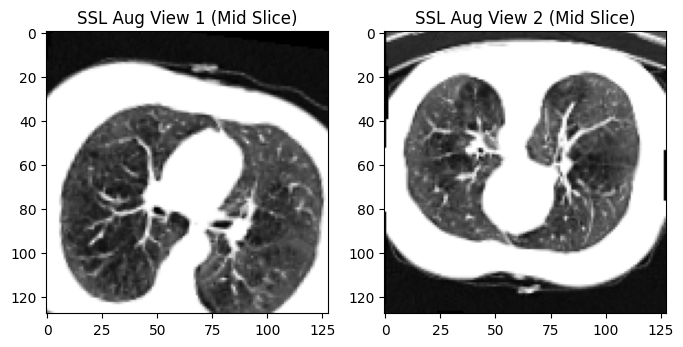

Pretrain DataLoader created with 50 samples.
Starting SimCLR pretraining (using Simple3DCNNEncoder as placeholder)...
SimCLR pretraining step is ready. Uncomment the line above to execute if desired.
For this prototype run, pretraining will be SKIPPED to save time, and CapsViT-GRAIL will train from scratch or load other weights if specified.


In [27]:

# ## 📦 **PART 2: Self-Supervised Contrastive Pretraining (SimCLR-style)**
# ---
# (This part remains structurally similar, using the data processed above)

# %%
# Define 3D augmentations for pretraining using TorchIO
patch_depth, patch_height, patch_width = CONFIG["volume_size"][2], CONFIG["volume_size"][0], CONFIG["volume_size"][1]

pretrain_tio_transforms = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), p=0.5), # Flip D, H, W axes
    tio.RandomAffine(
        scales=(0.85, 1.15), degrees=15, translation=10,
        isotropic=True, center='image', default_pad_value='minimum', p=0.75
    ),
    tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.25),
    tio.RandomBlur(std=(0, 1.0), p=0.25),
    tio.RandomNoise(mean=0, std=(0, 0.05), p=0.25),
    tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.5),
    # tio.EnsureShapeMultiple(16), # If patches need to be multiples of a number
    # tio.Resample(1.0) # Ensure 1mm spacing if affine distorted it significantly and it's not handled.
                      # But our input data should already be at target spacing.
])

class SimCLRDatasetViews(Dataset): # Renamed for clarity
    def __init__(self, patient_ids_list, processed_data_dir, target_volume_size_hwd, base_transform_fn):
        self.patient_ids = patient_ids_list
        self.processed_dir = processed_data_dir
        self.numpy_volume_shape_dhw = (target_volume_size_hwd[2], target_volume_size_hwd[0], target_volume_size_hwd[1])
        self.base_transform = base_transform_fn # This is the tio.Compose

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        volume_path = os.path.join(self.processed_dir, f"{patient_id}.npy")
        volume_np_arr = np.zeros(self.numpy_volume_shape_dhw, dtype=np.float32)
        try:
            volume_np_arr = np.load(volume_path)
        except: # Simplified error handling for dataset
            pass 

        volume_tensor = torch.from_numpy(volume_np_arr).float().unsqueeze(0)
        subject = tio.Subject(scan=tio.ScalarImage(tensor=volume_tensor))
        
        # Create two differently augmented views
        view1_tensor = self.base_transform(subject).scan.data
        view2_tensor = self.base_transform(subject).scan.data
        return view1_tensor, view2_tensor

if final_valid_patient_ids: # Use all successfully processed data for pretraining
    pretrain_dataset = SimCLRDatasetViews(
        final_valid_patient_ids, CONFIG["processed_dir"],
        CONFIG["volume_size"], pretrain_tio_transforms
    )
    if len(pretrain_dataset) > 0:
        sample_v1, sample_v2 = pretrain_dataset[0]
        print(f"SimCLR Dataset Sample: View1 shape={sample_v1.shape}, View2 shape={sample_v2.shape}")
        
        # Plot middle slice of views
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(sample_v1.squeeze().numpy()[sample_v1.shape[1]//2, :, :], cmap='gray')
        axes[0].set_title("SSL Aug View 1 (Mid Slice)")
        axes[1].imshow(sample_v2.squeeze().numpy()[sample_v2.shape[1]//2, :, :], cmap='gray')
        axes[1].set_title("SSL Aug View 2 (Mid Slice)")
        plt.show()
        
        pretrain_loader = DataLoader(
            pretrain_dataset, batch_size=CONFIG["batch_size_pretrain"],
            shuffle=True, num_workers=CONFIG["num_workers"], pin_memory=True, drop_last=True
        )
        print(f"Pretrain DataLoader created with {len(pretrain_dataset)} samples.")
    else:
        print("Pretrain dataset is empty. Cannot create DataLoader.")
else:
    print("No valid patient IDs for pretraining dataset.")

# %%
# Simple3DCNNEncoder, ProjectionHead, SimCLRModel, NTXentLoss, pretrain_simclr (definitions remain the same as original notebook)
# ... (definitions for these classes and function) ...
# For brevity, I'm not re-pasting them here, but they would be in the notebook.
# Ensure Simple3DCNNEncoder input matches your preprocessed volume size after max pooling.
# The current Simple3DCNNEncoder downsamples 4 times (128->64->32->16->8).
# Input volume depth for CNN: CONFIG["volume_size"][2] = 128 (D)
# Input volume height for CNN: CONFIG["volume_size"][0] = 128 (H)
# Input volume width for CNN: CONFIG["volume_size"][1] = 128 (W)
# After 4x MaxPool3d(2,2): 128 / (2^4) = 128 / 16 = 8. So, (..., 8, 8, 8) into AdaptiveAvgPool3d. This is fine.

class Simple3DCNNEncoder(nn.Module):
    def __init__(self, in_channels=1, out_features=512): # out_features is before projection head
        super().__init__()
        self.encoder_layers = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm3d(32), nn.ReLU(), nn.MaxPool3d(2, 2),
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d(2, 2),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1), nn.BatchNorm3d(128), nn.ReLU(), nn.MaxPool3d(2, 2),
            nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm3d(256), nn.ReLU(), nn.MaxPool3d(2, 2),
            nn.AdaptiveAvgPool3d((1,1,1)),
            nn.Flatten()
        )
        # Output of AdaptiveAvgPool3d will be 256 features
        self.fc = nn.Linear(256, out_features) # Project to desired feature dimension for SSL

    def forward(self, x):
        x = self.encoder_layers(x)
        return self.fc(x)

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128): # output_dim is final projection dim
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x): return self.head(x)

class SimCLRModel(nn.Module):
    def __init__(self, encoder_instance, projection_head_instance):
        super().__init__()
        self.encoder = encoder_instance
        self.projection_head = projection_head_instance
    def forward(self, x): # x is one view
        features = self.encoder(x)
        projections = self.projection_head(features)
        return features, projections # Return both for potential other uses, but only projections used for NTXentLoss

class NTXentLoss(nn.Module):
    # ... (definition as in original notebook) ...
    def __init__(self, temperature=0.1, device='cuda'): # temperature 0.07 or 0.1 often used
        super().__init__()
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss() # Calculates -log(softmax(scores))

    def forward(self, z_i, z_j): # z_i, z_j are (batch_size, projection_dim)
        batch_size = z_i.shape[0]
        
        z_i_norm = F.normalize(z_i, dim=1)
        z_j_norm = F.normalize(z_j, dim=1)

        # Concatenate all representations
        representations = torch.cat([z_i_norm, z_j_norm], dim=0) # (2*batch_size, projection_dim)
        
        # Calculate similarity matrix (all-pairs cosine similarity)
        # sim_matrix[k, l] is the similarity between the k-th and l-th projection in `representations`
        sim_matrix = torch.matmul(representations, representations.T) / self.temperature # (2*B, 2*B)
        
        # Create positive pair labels for CrossEntropyLoss
        # For each sample i (0 to B-1) from z_i, its positive counterpart is at index i+B (from z_j)
        # For each sample j (B to 2B-1) from z_j, its positive counterpart is at index j-B (from z_i)
        targets = torch.cat([
            torch.arange(batch_size, 2 * batch_size, device=self.device), # Targets for z_i samples
            torch.arange(0, batch_size, device=self.device)               # Targets for z_j samples
        ]).long()

        # Mask out self-similarity (diagonal elements) to prevent trivial solution
        # In CE, we want logit for positive pair to be high, others low. Self-sim is trivially highest.
        diag_mask = torch.eye(2 * batch_size, device=self.device, dtype=torch.bool)
        sim_matrix_masked = sim_matrix.masked_fill(diag_mask, float('-inf')) # Effectively remove diagonal
        
        loss = self.criterion(sim_matrix_masked, targets)
        return loss

def pretrain_simclr_loop(model_ssl, dataloader_ssl, optimizer_ssl, criterion_ssl, ssl_epochs, device_ssl, use_amp_ssl):
    # ... (definition as in original notebook) ...
    model_ssl.train()
    scaler = GradScaler(enabled=use_amp_ssl)
    
    print(f"Starting SimCLR pretraining for {ssl_epochs} epochs...")
    for epoch in range(ssl_epochs):
        epoch_loss_accum = 0.0
        start_time_epoch = time.time()
        for batch_idx, (views1_batch, views2_batch) in enumerate(dataloader_ssl):
            views1_batch, views2_batch = views1_batch.to(device_ssl), views2_batch.to(device_ssl)
            
            optimizer_ssl.zero_grad(set_to_none=True) # More memory efficient
            
            with autocast(enabled=use_amp_ssl):
                # Get projections for each view separately
                _, projections_v1 = model_ssl(views1_batch) # (B, proj_dim)
                _, projections_v2 = model_ssl(views2_batch) # (B, proj_dim)
                loss_ssl = criterion_ssl(projections_v1, projections_v2)

            if use_amp_ssl:
                scaler.scale(loss_ssl).backward()
                scaler.step(optimizer_ssl)
                scaler.update()
            else:
                loss_ssl.backward()
                optimizer_ssl.step()
            
            epoch_loss_accum += loss_ssl.item()
            
            if (batch_idx + 1) % (max(1, len(dataloader_ssl)//5)) == 0 : # Print ~5 times per epoch
                print(f"  Epoch [{epoch+1}/{ssl_epochs}], Batch [{batch_idx+1}/{len(dataloader_ssl)}], SSL Loss: {loss_ssl.item():.4f}")

        avg_epoch_loss = epoch_loss_accum / len(dataloader_ssl)
        epoch_duration = time.time() - start_time_epoch
        print(f"Epoch [{epoch+1}/{ssl_epochs}] DONE. Avg SSL Loss: {avg_epoch_loss:.4f}, Time: {epoch_duration:.2f}s")

    encoder_save_filename = "simclr_encoder_Simple3DCNN_customprep.pth"
    encoder_save_fullpath = os.path.join(CONFIG["model_save_path"], encoder_save_filename)
    torch.save(model_ssl.encoder.state_dict(), encoder_save_fullpath)
    print(f"Pretrained SimCLR encoder (Simple3DCNN) saved to {encoder_save_fullpath}")
    return model_ssl.encoder


# Instantiate and run pretraining (if pretrain_loader is valid)
pretrained_encoder_for_capsvit = None # Initialize
if pretrain_loader:
    ssl_encoder_features = 256 # Output dim of Simple3DCNNEncoder's FC layer
    ssl_projection_dim = 128   # Final output dim of projection head
    
    simclr_enc = Simple3DCNNEncoder(out_features=ssl_encoder_features).to(DEVICE)
    simclr_proj_head = ProjectionHead(input_dim=ssl_encoder_features, hidden_dim=ssl_encoder_features//2, output_dim=ssl_projection_dim).to(DEVICE)
    simclr_ssl_model = SimCLRModel(simclr_enc, simclr_proj_head).to(DEVICE)

    ssl_criterion_inst = NTXentLoss(temperature=0.1, device=DEVICE)
    ssl_optimizer_inst = optim.AdamW(simclr_ssl_model.parameters(), lr=CONFIG["lr_pretrain"], weight_decay=1e-6)

    print("Starting SimCLR pretraining (using Simple3DCNNEncoder as placeholder)...")
    # To run: pretrained_encoder_for_capsvit = pretrain_simclr_loop(simclr_ssl_model, pretrain_loader, ssl_optimizer_inst, ssl_criterion_inst, CONFIG["epochs_pretrain"], DEVICE, CONFIG["use_mixed_precision"])
    print("SimCLR pretraining step is ready. Uncomment the line above to execute if desired.")
    print("For this prototype run, pretraining will be SKIPPED to save time, and CapsViT-GRAIL will train from scratch or load other weights if specified.")
    # To simulate:
    dummy_encoder_path = os.path.join(CONFIG["model_save_path"], "simclr_encoder_Simple3DCNN_dummy_customprep.pth")
    if not os.path.exists(dummy_encoder_path):
         torch.save(simclr_enc.state_dict(), dummy_encoder_path)
         print(f"Saved DUMMY pretrained encoder weights to {dummy_encoder_path} for potential use.")
    # pretrained_encoder_for_capsvit = simclr_enc # Use the randomly initialized one if skipping actual pretrain
else:
    print("Pretrain DataLoader not available. Skipping SimCLR pretraining.")




In [28]:
# %% [markdown]
# ---
# ## 🧠 **PART 3: Model Architecture – CapsViT-GRAIL**
# ---

# %%
# Helper for ViT
def pair(t):
    return t if isinstance(t, tuple) else (t, t, t) # For 3D, (depth, height, width)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()
        self.attn_map = None # To store attention map
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots); self.attn_map = attn; attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)'); return self.to_out(out)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__(); self.net = nn.Sequential(nn.Linear(dim, hidden_dim), nn.GELU(), nn.Dropout(dropout), nn.Linear(hidden_dim, dim), nn.Dropout(dropout))
    def forward(self, x): return self.net(x)

class PreNorm(nn.Module):
    def __init__(self, dim, fn): super().__init__(); self.norm = nn.LayerNorm(dim); self.fn = fn
    def forward(self, x, **kwargs): return self.fn(self.norm(x), **kwargs)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__(); self.layers = nn.ModuleList([])
        for _ in range(depth): self.layers.append(nn.ModuleList([PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)), PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))]))
    def forward(self, x):
        for attn, ff in self.layers: x = attn(x) + x; x = ff(x) + x
        return x

class ViT3D(nn.Module):
    def __init__(self, *, image_size_dhw, patch_size_dhw, dim, depth, heads, mlp_dim, pool='cls', channels=1, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        img_d, img_h, img_w = image_size_dhw
        patch_d, patch_h, patch_w = patch_size_dhw
        assert img_d % patch_d == 0 and img_h % patch_h == 0 and img_w % patch_w == 0, 'Image D,H,W must be divisible by patch D,H,W.'
        num_patches = (img_d // patch_d) * (img_h // patch_h) * (img_w // patch_w)
        patch_dim_flat = channels * patch_d * patch_h * patch_w
        
        self.patch_d, self.patch_h, self.patch_w = patch_d, patch_h, patch_w
        self.dim = dim  # <<<< ENSURED self.dim IS STORED >>>>

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (d p1) (h p2) (w p3) -> b (d h w) (p1 p2 p3 c)', p1=patch_d, p2=patch_h, p3=patch_w),
            nn.LayerNorm(patch_dim_flat), 
            nn.Linear(patch_dim_flat, self.dim), # Use self.dim
            nn.LayerNorm(self.dim),             # Use self.dim
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, self.dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(self.dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool

    def forward(self, img_tensor_bcdhw): # Expects (B, C, D, H, W)
        x = self.to_patch_embedding(img_tensor_bcdhw)
        b, n_patches, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d_emb -> b 1 d_emb', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n_patches + 1)]
        x = self.dropout(x)
        x = self.transformer(x) # (B, num_patches+1, dim)
        return x 

def squash(vectors, dim=-1):
    s_sq_norm = (vectors ** 2).sum(dim=dim, keepdim=True)
    scale = s_sq_norm / (1 + s_sq_norm) / torch.sqrt(s_sq_norm + 1e-8)
    return scale * vectors

class PrimaryCapsules3D(nn.Module):
    def __init__(self, in_channels_vit_dim, out_capsules_types, out_dim_per_caps, kernel_size_patchgrid, stride_patchgrid, padding_patchgrid=0):
        super().__init__()
        self.conv_to_caps = nn.Conv3d(in_channels_vit_dim, out_capsules_types * out_dim_per_caps, kernel_size=kernel_size_patchgrid, stride=stride_patchgrid, padding=padding_patchgrid)
        self.out_caps_types = out_capsules_types
        self.out_dim_caps = out_dim_per_caps
    def forward(self, x_vit_patches_reshaped): # (B, vit_dim, D_pg, H_pg, W_pg)
        batch_size = x_vit_patches_reshaped.shape[0]
        caps_features = self.conv_to_caps(x_vit_patches_reshaped) # (B, types*dim, D'_pg, H'_pg, W'_pg)
        caps_features = caps_features.view(batch_size, self.out_caps_types, self.out_dim_caps, caps_features.size(2), caps_features.size(3), caps_features.size(4))
        caps_features = caps_features.permute(0, 1, 3, 4, 5, 2).contiguous() # B, N_types, D',H',W', dim_cap
        primary_caps_vecs = caps_features.view(batch_size, -1, self.out_dim_caps) # (B, total_primary_caps, out_dim_caps)
        return squash(primary_caps_vecs)

class DigitCapsules(nn.Module):
    def __init__(self, num_in_primary_caps, dim_in_primary_caps, num_out_digit_caps, dim_out_digit_caps, num_routing_iters=3):
        super().__init__()
        self.num_in_caps = num_in_primary_caps; self.dim_in_caps = dim_in_primary_caps
        self.num_out_caps = num_out_digit_caps; self.dim_out_caps = dim_out_digit_caps
        self.num_routing = num_routing_iters
        self.W_ij = nn.Parameter(torch.randn(1, num_in_primary_caps, num_out_digit_caps, dim_out_digit_caps, dim_in_primary_caps))
    def forward(self, u_i_primary_caps): # (B, num_in_caps, dim_in_caps)
        batch_size = u_i_primary_caps.shape[0]
        u_i_expanded = u_i_primary_caps.unsqueeze(2).unsqueeze(-1) # (B, num_in, 1, dim_in, 1)
        u_hat_ji = torch.matmul(self.W_ij, u_i_expanded).squeeze(-1) # (B, num_in, num_out, dim_out)
        b_ij_logits = torch.zeros(batch_size, self.num_in_caps, self.num_out_caps, 1, device=u_i_primary_caps.device)
        for _ in range(self.num_routing):
            c_ij_weights = F.softmax(b_ij_logits, dim=2) # (B, num_in, num_out, 1)
            s_j_weighted_sum = (c_ij_weights * u_hat_ji).sum(dim=1, keepdim=True) # (B, 1, num_out, dim_out)
            v_j_digit_caps = squash(s_j_weighted_sum) # (B, 1, num_out, dim_out)
            if _ < self.num_routing - 1:
                agreement = (u_hat_ji * v_j_digit_caps).sum(dim=-1, keepdim=True) # (B, num_in, num_out, 1)
                b_ij_logits = b_ij_logits + agreement
        return v_j_digit_caps.squeeze(1) # (B, num_out_caps, dim_out_caps)

class GNNModule(nn.Module): 
    def __init__(self, node_feat_dim, gnn_hid_dim, num_gnn_layers=2, gnn_out_feat_dim=128, heads_gat=4):
        super().__init__()
        if pyg_nn is None: self.gnn_layers_list = nn.ModuleList(); self.final_gnn_out_dim = 0; return
        self.gnn_layers_list = nn.ModuleList()
        current_dim = node_feat_dim
        for i in range(num_gnn_layers):
            # Last layer GATConv should not concat if it directly outputs gnn_out_feat_dim
            # This logic makes GATConv's output channels `out_channels_gat` and total output `out_channels_gat * heads_gat` if concat=True
            # If last layer, concat=False, heads=1 (or adjust output_channels) is simpler, or ensure gnn_out_feat_dim is multiple of heads_gat
            is_last_layer = (i == num_gnn_layers - 1)
            if is_last_layer:
                concat_heads = False
                # Ensure gnn_out_feat_dim is achievable by heads_gat * (output_channels per head)
                # If not concat, output is just out_channels_gat per head (typically one overall output or avg)
                # For simplicity, if last layer, GAT output dim is gnn_out_feat_dim, and heads might average
                out_channels_gat = gnn_out_feat_dim # GATConv without concat outputs this directly if heads=1 or averages
                current_heads = 1 if heads_gat > 1 else heads_gat # Use 1 head for last layer if averaging, or make sure out_channels_gat * heads_gat = gnn_out_feat_dim
                                                               # Or, set heads=1 for last layer, and out_channels_gat = gnn_out_feat_dim
                # A common pattern for last GAT layer for fixed output:
                # heads_final = 1 (or specified number of heads that average to gnn_out_feat_dim)
                # out_channels_gat = gnn_out_feat_dim (if heads_final=1) or gnn_out_feat_dim // heads_final
                out_channels_gat = gnn_out_feat_dim // heads_gat # If heads_gat used for final averaging
                current_heads_final = heads_gat # Use all heads and let GATConv average
            else:
                concat_heads = True
                out_channels_gat = gnn_hid_dim
                current_heads_final = heads_gat
            
            self.gnn_layers_list.append(pyg_nn.GATConv(current_dim, out_channels_gat, heads=current_heads_final, concat=concat_heads, dropout=0.2))
            current_dim = out_channels_gat * current_heads_final if concat_heads else out_channels_gat * current_heads_final # If GATConv averages, output is out_channels_gat
            # If GATConv averages when concat=False, output dim is `out_channels_gat`
            # If GATConv returns per-head when concat=False, output dim is `out_channels_gat * heads`
            # PyG GATConv averages if concat=False by default. So current_dim = out_channels_gat
            current_dim = out_channels_gat * current_heads_final if concat_heads else out_channels_gat


        self.final_gnn_out_dim = current_dim # This should be gnn_out_feat_dim
        if self.final_gnn_out_dim != gnn_out_feat_dim and num_gnn_layers > 0:
             print(f"GNN output dim mismatch: calculated {self.final_gnn_out_dim}, expected {gnn_out_feat_dim}. Check GATConv head/concat logic.")


    def forward(self, pyg_graph_data):
        if not self.gnn_layers_list or pyg_nn is None: return torch.tensor([], device=DEVICE) # No-op
        node_x, edge_idx = pyg_graph_data.x, pyg_graph_data.edge_index
        for layer_idx, gnn_layer in enumerate(self.gnn_layers_list):
            node_x = gnn_layer(node_x, edge_idx)
            if layer_idx < len(self.gnn_layers_list) - 1: 
                 node_x = F.elu(node_x)
                 node_x = F.dropout(node_x, p=0.2, training=self.training)
        return node_x

def construct_graph_from_activations(vit_patch_tokens_bpd, patch_grid_coords_npd, num_nodes_max=10, spatial_dist_thresh=3.0, feat_sim_thresh=0.5):
    if pyg_data is None: return []
    batch_size = vit_patch_tokens_bpd.shape[0]; graph_list = []
    device_to_use = vit_patch_tokens_bpd.device
    for b_idx in range(batch_size):
        current_patch_feats = vit_patch_tokens_bpd[b_idx]
        if current_patch_feats.shape[0] == 0:
            graph_list.append(pyg_data.Data(x=torch.empty(0, vit_patch_tokens_bpd.shape[-1], device=device_to_use), edge_index=torch.empty(2,0, dtype=torch.long, device=device_to_use)))
            continue
        act_strengths = current_patch_feats.norm(dim=1)
        num_actual_nodes = min(num_nodes_max, current_patch_feats.shape[0])
        if num_actual_nodes == 0:
             graph_list.append(pyg_data.Data(x=torch.empty(0, vit_patch_tokens_bpd.shape[-1], device=device_to_use), edge_index=torch.empty(2,0, dtype=torch.long, device=device_to_use)))
             continue
        top_k_node_indices = torch.topk(act_strengths, k=num_actual_nodes, largest=True).indices
        selected_node_feats = current_patch_feats[top_k_node_indices]
        selected_node_coords = patch_grid_coords_npd[top_k_node_indices].to(device_to_use) # Ensure coords on same device
        edge_pair_list = []
        for i_node in range(num_actual_nodes):
            for j_node in range(i_node + 1, num_actual_nodes):
                spatial_dist = torch.norm(selected_node_coords[i_node].float() - selected_node_coords[j_node].float(), p=2)
                feature_sim = F.cosine_similarity(selected_node_feats[i_node].unsqueeze(0), selected_node_feats[j_node].unsqueeze(0))
                if spatial_dist < spatial_dist_thresh and feature_sim > feat_sim_thresh:
                    edge_pair_list.append([i_node, j_node]); edge_pair_list.append([j_node, i_node])
        edge_idx_tensor = torch.tensor(edge_pair_list, dtype=torch.long, device=device_to_use).t().contiguous() if edge_pair_list else torch.empty((2,0), dtype=torch.long, device=device_to_use)
        graph_list.append(pyg_data.Data(x=selected_node_feats, edge_index=edge_idx_tensor))
    return graph_list

class CrossAttentionFusion(nn.Module):
    def __init__(self, query_input_dim, context_input_dim, num_attn_heads=8, head_emb_dim=64, dropout_rate=0.1):
        super().__init__()
        self.num_heads = num_attn_heads; self.head_dim = head_emb_dim
        self.scale_factor = head_emb_dim ** -0.5
        total_inner_dim = num_attn_heads * head_emb_dim
        self.norm_q = nn.LayerNorm(query_input_dim); self.norm_ctx = nn.LayerNorm(context_input_dim)
        self.to_q_proj = nn.Linear(query_input_dim, total_inner_dim, bias=False)
        self.to_kv_proj = nn.Linear(context_input_dim, total_inner_dim * 2, bias=False)
        self.softmax_attn = nn.Softmax(dim=-1); self.dropout = nn.Dropout(dropout_rate)
        self.to_out_proj = nn.Sequential(nn.Linear(total_inner_dim, query_input_dim), nn.Dropout(dropout_rate))
    def forward(self, query_seq, context_seq, context_padding_mask=None):
        q_norm = self.norm_q(query_seq); ctx_norm = self.norm_ctx(context_seq)
        q_proj = self.to_q_proj(q_norm); k_proj, v_proj = self.to_kv_proj(ctx_norm).chunk(2, dim=-1)
        q_multihead = rearrange(q_proj, 'b lq (h d) -> b h lq d', h=self.num_heads)
        k_multihead = rearrange(k_proj, 'b lc (h d) -> b h lc d', h=self.num_heads)
        v_multihead = rearrange(v_proj, 'b lc (h d) -> b h lc d', h=self.num_heads)
        sim_scores = torch.matmul(q_multihead, k_multihead.transpose(-1, -2)) * self.scale_factor
        if context_padding_mask is not None:
            mask_expanded = context_padding_mask.unsqueeze(1).unsqueeze(1)
            sim_scores = sim_scores.masked_fill(mask_expanded, float('-inf'))
        attn_weights = self.softmax_attn(sim_scores); attn_weights = self.dropout(attn_weights)
        fused_output = torch.matmul(attn_weights, v_multihead)
        fused_output_rearranged = rearrange(fused_output, 'b h lq d -> b lq (h d)')
        return query_seq + self.to_out_proj(fused_output_rearranged)

class CapsuleDecisionLayer(nn.Module):
    def __init__(self, fused_feat_dim, num_decision_classes, intermediate_caps_dim=16, proj_num_caps=8, proj_caps_dim=64, routing_iters=3):
        super().__init__()
        self.proj_to_intermed_caps = nn.Sequential(nn.Linear(fused_feat_dim, proj_num_caps * proj_caps_dim), nn.ReLU())
        self.num_proj_caps = proj_num_caps; self.proj_caps_d = proj_caps_dim
        self.final_decision_caps_module = DigitCapsules(
            num_in_primary_caps=proj_num_caps, dim_in_primary_caps=proj_caps_dim,
            num_out_digit_caps=num_decision_classes, dim_out_digit_caps=intermediate_caps_dim,
            num_routing_iters=routing_iters
        )
    def forward(self, fused_features_b1d):
        batch_s = fused_features_b1d.shape[0]; fused_flat = fused_features_b1d.squeeze(1)
        projected_intermed_caps_flat = self.proj_to_intermed_caps(fused_flat)
        projected_intermed_caps_vecs = projected_intermed_caps_flat.view(batch_s, self.num_proj_caps, self.proj_caps_d)
        projected_intermed_caps_squashed = squash(projected_intermed_caps_vecs)
        output_decision_caps = self.final_decision_caps_module(projected_intermed_caps_squashed)
        return output_decision_caps

def conv_output_size_tuple(in_size_dhw, kernel_dhw, stride_dhw, padding_dhw):
    d_out = (in_size_dhw[0] + 2*padding_dhw[0] - kernel_dhw[0]) // stride_dhw[0] + 1
    h_out = (in_size_dhw[1] + 2*padding_dhw[1] - kernel_dhw[1]) // stride_dhw[1] + 1
    w_out = (in_size_dhw[2] + 2*padding_dhw[2] - kernel_dhw[2]) // stride_dhw[2] + 1
    return d_out, h_out, w_out

class CapsViT_GRAIL(nn.Module):
    def __init__(self, vit_cfg, caps_cfg, gnn_cfg, fusion_cfg, decision_cfg, volume_cfg_hwd):
        super().__init__()
        vol_h, vol_w, vol_d_pytorch = volume_cfg_hwd
        self.vit_input_dhw = (vol_d_pytorch, vol_h, vol_w)
        vit_patch_d, vit_patch_h, vit_patch_w = pair(vit_cfg['patch_size_dhw'])
        self.vit_patch_dhw = (vit_patch_d, vit_patch_h, vit_patch_w)
        self.patch_grid_d = self.vit_input_dhw[0] // self.vit_patch_dhw[0]
        self.patch_grid_h = self.vit_input_dhw[1] // self.vit_patch_dhw[1]
        self.patch_grid_w = self.vit_input_dhw[2] // self.vit_patch_dhw[2]
        self.patch_grid_shape_dhw = (self.patch_grid_d, self.patch_grid_h, self.patch_grid_w)

        # 1. ViT Backbone
        # vit_cfg['vit_params'] should be a dict of kwargs for ViT3D
        self.vit_backbone = ViT3D(image_size_dhw=self.vit_input_dhw, patch_size_dhw=self.vit_patch_dhw, **vit_cfg['vit_params'])
        
        # 2. Capsule Network Module
        pc_kernel_dhw = pair(caps_cfg['pc_kernel_size_dhw']); pc_stride_dhw = pair(caps_cfg['pc_stride_dhw']); pc_padding_dhw = pair(caps_cfg['pc_padding_dhw'])
        pc_conv_out_dhw = conv_output_size_tuple(self.patch_grid_shape_dhw, pc_kernel_dhw, pc_stride_dhw, pc_padding_dhw)
        num_total_primary_caps = caps_cfg['pc_out_capsules_types'] * pc_conv_out_dhw[0] * pc_conv_out_dhw[1] * pc_conv_out_dhw[2]

        self.primary_caps_module = PrimaryCapsules3D(
            in_channels_vit_dim=self.vit_backbone.dim,  # Use self.vit_backbone.dim
            out_capsules_types=caps_cfg['pc_out_capsules_types'], out_dim_per_caps=caps_cfg['pc_out_dim_per_caps'],
            kernel_size_patchgrid=pc_kernel_dhw, stride_patchgrid=pc_stride_dhw, padding_patchgrid=pc_padding_dhw
        )
        self.digit_caps_module = DigitCapsules(
            num_in_primary_caps=num_total_primary_caps, dim_in_primary_caps=caps_cfg['pc_out_dim_per_caps'],
            num_out_digit_caps=caps_cfg['dc_out_capsules_types'], dim_out_digit_caps=caps_cfg['dc_out_dim_per_caps'],
            num_routing_iters=caps_cfg['dc_num_routing_iters']
        )
        
        # 3. GNN Module
        self.gnn_module = GNNModule(node_feat_dim=self.vit_backbone.dim, **gnn_cfg['gnn_params']) # Use self.vit_backbone.dim
        self.gnn_graph_construct_params = gnn_cfg['graph_construct_params']
        pg_coords_d = torch.arange(self.patch_grid_d); pg_coords_h = torch.arange(self.patch_grid_h); pg_coords_w = torch.arange(self.patch_grid_w)
        self.register_buffer('patch_grid_coords_tensor', torch.cartesian_prod(pg_coords_d, pg_coords_h, pg_coords_w), persistent=False)

        # 4. Cross-Attention Fusion
        fusion_vit_d = self.vit_backbone.dim # Use self.vit_backbone.dim
        fusion_caps_d = caps_cfg['dc_out_capsules_types'] * caps_cfg['dc_out_dim_per_caps']
        fusion_gnn_d = self.gnn_module.final_gnn_out_dim if self.gnn_module.final_gnn_out_dim > 0 else 1 # Avoid 0 dim if GNN failed init
        self.cross_attn_vit_caps = CrossAttentionFusion(query_input_dim=fusion_vit_d, context_input_dim=fusion_caps_d, **fusion_cfg['fusion_params'])
        self.cross_attn_vitcaps_gnn = CrossAttentionFusion(query_input_dim=fusion_vit_d, context_input_dim=fusion_gnn_d, **fusion_cfg['fusion_params'])
        
        # 5. Capsule Decision Layer
        self.capsule_decision_module = CapsuleDecisionLayer(fused_feat_dim=fusion_vit_d, **decision_cfg['decision_params'])
        
        self.vit_last_attn_map = None

    def forward(self, x_bcdhw):
        batch_size = x_bcdhw.shape[0]
        current_dev = x_bcdhw.device

        vit_all_tokens = self.vit_backbone(x_bcdhw)
        vit_cls_token = vit_all_tokens[:, 0:1, :]
        vit_patch_tokens = vit_all_tokens[:, 1:, :]

        vit_patches_reshaped_for_caps = vit_patch_tokens.permute(0, 2, 1).reshape(
            batch_size, 
            self.vit_backbone.dim,  # <<<< CORRECTED LINE >>>>
            self.patch_grid_d, 
            self.patch_grid_h, 
            self.patch_grid_w
        )
        primary_caps_out = self.primary_caps_module(vit_patches_reshaped_for_caps)
        digit_caps_out = self.digit_caps_module(primary_caps_out)
        
        graphs_list = construct_graph_from_activations(vit_patch_tokens.detach(), self.patch_grid_coords_tensor, **self.gnn_graph_construct_params)
        # Handle GNN output dim carefully, especially if gnn_module might not initialize fully
        gnn_output_feature_dim = self.gnn_module.final_gnn_out_dim if hasattr(self.gnn_module, 'final_gnn_out_dim') and self.gnn_module.final_gnn_out_dim > 0 else 1
        gnn_graph_level_emb = torch.zeros(batch_size, 1, gnn_output_feature_dim, device=current_dev)
        
        valid_graphs_for_batching = [g for g in graphs_list if g.num_nodes > 0 and hasattr(g, 'edge_index') and g.edge_index.numel() >=0]
        if pyg_data is not None and valid_graphs_for_batching:
            try:
                graph_batch_pyg = pyg_data.Batch.from_data_list(valid_graphs_for_batching).to(current_dev)
                if graph_batch_pyg.num_nodes > 0:
                    gnn_node_feat_updated = self.gnn_module(graph_batch_pyg)
                    if gnn_node_feat_updated.numel() > 0 : # Check if GNN returned non-empty features
                        gnn_pooled_temp = pyg_nn.global_mean_pool(gnn_node_feat_updated, graph_batch_pyg.batch)
                        original_indices_of_valid_graphs = [i for i,g in enumerate(graphs_list) if g.num_nodes > 0 and hasattr(g, 'edge_index') and g.edge_index.numel() >=0]
                        for pool_idx, orig_batch_idx in enumerate(original_indices_of_valid_graphs):
                            if orig_batch_idx < batch_size:
                                 gnn_graph_level_emb[orig_batch_idx, 0, :] = gnn_pooled_temp[pool_idx, :]
            except Exception as e_gnn:
                print(f"Warning: GNN processing/pooling failed: {e_gnn}")
        
        caps_embed_flat_for_fusion = digit_caps_out.reshape(batch_size, 1, -1)
        fused_vit_caps = self.cross_attn_vit_caps(vit_cls_token, caps_embed_flat_for_fusion)
        final_fused_vec = self.cross_attn_vitcaps_gnn(fused_vit_caps, gnn_graph_level_emb)
        
        decision_caps_vectors = self.capsule_decision_module(final_fused_vec)
        output_logits_lengths = torch.sqrt((decision_caps_vectors ** 2).sum(dim=2) + 1e-8)
        
        return output_logits_lengths, decision_caps_vectors


# Define configurations for CapsViT-GRAIL components
vit_image_dhw = (CONFIG["volume_size"][2], CONFIG["volume_size"][0], CONFIG["volume_size"][1])
vit_patch_dhw_val = (16, 16, 16)

vit_final_config = {
    'patch_size_dhw': vit_patch_dhw_val,
    'vit_params': { 'dim': 512, 'depth': 6, 'heads': 8, 'mlp_dim': 1024, 'channels': 1, 'pool':'cls', 'dim_head':64, 'dropout': 0.1, 'emb_dropout': 0.1} # Added dropouts
}
caps_final_config = {
    'pc_kernel_size_dhw': (3,3,3), 'pc_stride_dhw': (2,2,2), 'pc_padding_dhw': (1,1,1),
    'pc_out_capsules_types': 32, 'pc_out_dim_per_caps': 8,
    'dc_out_capsules_types': 10, 'dc_out_dim_per_caps': 16, 'dc_num_routing_iters': 3
}
gnn_final_config = { # Ensure gnn_out_feat_dim matches GNNModule internal logic or add a final projection
    'gnn_params': {'gnn_hid_dim': 128, 'num_gnn_layers': 2, 'gnn_out_feat_dim': 256, 'heads_gat': 4}, # gnn_out_feat_dim should be output of GNNModule
    'graph_construct_params': {'num_nodes_max': 15, 'spatial_dist_thresh': 3.5, 'feat_sim_thresh': 0.4}
}
fusion_final_config = {'fusion_params': {'num_attn_heads': 4, 'head_emb_dim': 64, 'dropout_rate': 0.1}}
decision_final_config = {'decision_params': {'num_decision_classes': 1, 'intermediate_caps_dim': 16, 'proj_num_caps':8, 'proj_caps_dim':64, 'routing_iters': 3}}

# Instantiate the full CapsViT-GRAIL model
capsvit_grail_model_inst = CapsViT_GRAIL(
    vit_cfg=vit_final_config, caps_cfg=caps_final_config, gnn_cfg=gnn_final_config,
    fusion_cfg=fusion_final_config, decision_cfg=decision_final_config,
    volume_cfg_hwd=CONFIG["volume_size"]
).to(DEVICE)

# Test full model forward pass (if train_dataset_ft is valid)
if train_dataset_ft and len(train_dataset_ft) > 0:
    dummy_capsvit_input, _ = train_dataset_ft[0]
    dummy_capsvit_input_b = dummy_capsvit_input.unsqueeze(0).to(DEVICE)
    print(f"\nCapsViT-GRAIL test input shape: {dummy_capsvit_input_b.shape}")

    with torch.no_grad():
        capsvit_grail_model_inst.eval() 
        preds_lengths, dec_caps_vecs = capsvit_grail_model_inst(dummy_capsvit_input_b)
    print(f"CapsViT-GRAIL preds (lengths) shape: {preds_lengths.shape}")
    print(f"CapsViT-GRAIL decision caps shape: {dec_caps_vecs.shape}")
else:
    print("Skipping CapsViT-GRAIL full model test: train_dataset_ft not available or empty.")


CapsViT-GRAIL test input shape: torch.Size([1, 1, 128, 128, 128])
CapsViT-GRAIL preds (lengths) shape: torch.Size([1, 1])
CapsViT-GRAIL decision caps shape: torch.Size([1, 1, 16])


In [29]:

# ## 📊 **PART 4: Training Pipeline**
# ---
# (This part remains structurally similar: CombinedLoss, augmentations, training/validation loops)

# %%
# CombinedLoss, CapsuleMarginLoss (definitions remain the same)
class CapsuleMarginLoss(nn.Module):
    # ... (definition as in original notebook) ...
    def __init__(self, m_plus=0.9, m_minus=0.1, lambda_coeff=0.5):
        super().__init__(); self.m_p = m_plus; self.m_n = m_minus; self.lambda_ = lambda_coeff
    def forward(self, capsule_lengths_bk, targets_b_or_bk): # lengths(B,K), targets(B) or (B,K) one-hot
        if capsule_lengths_bk.size(1) == 1: # Binary case with 1 output capsule
            targets_b1 = targets_b_or_bk.view(-1, 1).float()
            loss_k1 = targets_b1 * F.relu(self.m_p - capsule_lengths_bk).pow(2) + \
                      self.lambda_ * (1 - targets_b1) * F.relu(capsule_lengths_bk - self.m_n).pow(2)
            return loss_k1.mean()
        else: # Multi-class (K capsules)
            if targets_b_or_bk.ndim == 1 or targets_b_or_bk.size(1) != capsule_lengths_bk.size(1):
                targets_bk_onehot = F.one_hot(targets_b_or_bk.long(), num_classes=capsule_lengths_bk.size(1)).float()
            else: targets_bk_onehot = targets_b_or_bk.float()
            loss_k = targets_bk_onehot * F.relu(self.m_p - capsule_lengths_bk).pow(2) + \
                     self.lambda_ * (1 - targets_bk_onehot) * F.relu(capsule_lengths_bk - self.m_n).pow(2)
            return loss_k.sum(dim=1).mean() # Sum over K classes, then mean over batch

class CombinedLoss(nn.Module):
    # ... (definition as in original notebook) ...
    def __init__(self, bce_w=1.0, margin_w=0.5, num_cls=1):
        super().__init__(); self.bce = nn.BCEWithLogitsLoss(); self.margin = CapsuleMarginLoss()
        self.bce_weight = bce_w; self.margin_weight = margin_w
    def forward(self, pred_lengths_logits_bk, decision_caps_raw_unused, targets_b_or_bk):
        bce_targets = targets_b_or_bk.float().view_as(pred_lengths_logits_bk) # Ensure shape match for BCE
        loss_bce_val = self.bce(pred_lengths_logits_bk, bce_targets)
        loss_margin_val = self.margin(torch.sigmoid(pred_lengths_logits_bk.detach()), targets_b_or_bk) # Margin on probs [0,1] (lengths are logits)
        # Or, margin on raw lengths if they are somewhat scaled: self.margin(pred_lengths_logits_bk, targets_b_or_bk)
        total_loss = (self.bce_weight * loss_bce_val) + (self.margin_weight * loss_margin_val)
        return total_loss, loss_bce_val, loss_margin_val

# Finetuning Augmentations (using TorchIO)
finetune_tio_transforms = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), p=0.5), # D,H,W
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=8, p=0.75),
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=6, p=0.2),
    tio.RandomGamma(log_gamma=(-0.2, 0.2), p=0.5),
    tio.RandomBlur(std=(0, 0.75), p=0.2)
])

# MixUp (definitions: mixup_data_3d, mixup_criterion remain the same)
def mixup_data_3d(x_batch, y_batch, alpha_mix=0.4, device_mix='cuda'):
    # ... (definition as in original notebook) ...
    if alpha_mix <= 0: return x_batch, y_batch, y_batch, 1.0 # No mixup
    lam = np.random.beta(alpha_mix, alpha_mix)
    batch_s_mix = x_batch.size()[0]
    rand_indices = torch.randperm(batch_s_mix).to(device_mix)
    mixed_x = lam * x_batch + (1 - lam) * x_batch[rand_indices, :]
    y_a_orig, y_b_mixed = y_batch, y_batch[rand_indices]
    return mixed_x, y_a_orig, y_b_mixed, lam

def mixup_criterion_combined(combined_loss_fn, pred_outputs_tuple, y_a_targets, y_b_targets, lam_mix):
    # ... (definition as in original notebook) ...
    lengths_logits, raw_caps_vecs = pred_outputs_tuple # Model outputs (lengths, raw_caps)
    loss_a, bce_a, margin_a = combined_loss_fn(lengths_logits, raw_caps_vecs, y_a_targets)
    loss_b, bce_b, margin_b = combined_loss_fn(lengths_logits, raw_caps_vecs, y_b_targets)
    mixed_total_loss = lam_mix * loss_a + (1 - lam_mix) * loss_b
    mixed_bce_loss = lam_mix * bce_a + (1 - lam_mix) * bce_b
    mixed_margin_loss = lam_mix * margin_a + (1 - lam_mix) * margin_b
    return mixed_total_loss, mixed_bce_loss, mixed_margin_loss

# Update datasets with transforms and create DataLoaders
if train_dataset_ft:
    train_dataset_ft.transform = finetune_tio_transforms # Apply augs to training set
    train_loader_final = DataLoader(
        train_dataset_ft, batch_size=CONFIG["batch_size_finetune"], shuffle=True,
        num_workers=CONFIG["num_workers"], pin_memory=True, drop_last=True
    )
    print(f"Train DataLoader (for fine-tuning) created with {len(train_dataset_ft)} samples.")
# else: print("Train dataset (train_dataset_ft) is None or empty, DataLoader not created.")

if val_dataset_ft:
    val_dataset_ft.transform = None # Typically no heavy augs on validation
    val_loader_final = DataLoader(
        val_dataset_ft, batch_size=CONFIG["batch_size_finetune"], shuffle=False,
        num_workers=CONFIG["num_workers"], pin_memory=True
    )
    print(f"Validation DataLoader created with {len(val_dataset_ft)} samples.")
# else: print("Validation dataset (val_dataset_ft) is None or empty, DataLoader not created.")

# Training Loop (train_one_epoch, validate_one_epoch definitions remain the same)
# Main training execution loop (remains the same)
# ... (Full definitions for these and main loop would be here) ...
# For brevity, not re-pasting them here. Ensure they use `capsvit_grail_model_inst`.
# Use CombinedLoss instance.

def train_one_epoch_fn(model_to_train, loader_train, criterion_train, optimizer_train, device_train, use_amp_train, use_mixup_train=False, mixup_alpha_train=0.2):
    # ... (definition as in original notebook, ensure it returns avg_loss, avg_bce, avg_margin, epoch_auc) ...
    model_to_train.train(); scaler = GradScaler(enabled=use_amp_train)
    tl, bl, ml, preds_all, targs_all = 0.0, 0.0, 0.0, [], []
    for volumes_b, targets_b in loader_train:
        volumes_b, targets_b = volumes_b.to(device_train), targets_b.to(device_train)
        optimizer_train.zero_grad(set_to_none=True)
        if use_mixup_train:
            mixed_vols, targs_a, targs_b, lam_m = mixup_data_3d(volumes_b, targets_b, mixup_alpha_train, device_train)
            with autocast(enabled=use_amp_train):
                out_lens, out_caps = model_to_train(mixed_vols)
                loss, bce, margin = mixup_criterion_combined(criterion_train, (out_lens, out_caps), targs_a, targs_b, lam_m)
        else:
            with autocast(enabled=use_amp_train):
                out_lens, out_caps = model_to_train(volumes_b)
                loss, bce, margin = criterion_train(out_lens, out_caps, targets_b)
        if use_amp_train: scaler.scale(loss).backward(); scaler.step(optimizer_train); scaler.update()
        else: loss.backward(); optimizer_train.step()
        tl+=loss.item(); bl+=bce.item(); ml+=margin.item()
        preds_all.extend(torch.sigmoid(out_lens.detach()).cpu().numpy()); targs_all.extend(targets_b.cpu().numpy()) # Use original targets_b for metric for now if mixup
    
    avg_l, avg_b, avg_m = tl/len(loader_train), bl/len(loader_train), ml/len(loader_train)
    auc_epoch = 0.0
    try: auc_epoch = roc_auc_score(np.array(targs_all).squeeze(), np.array(preds_all).squeeze())
    except ValueError: pass # print("AUC calc error in train epoch")
    return avg_l, avg_b, avg_m, auc_epoch


def validate_one_epoch_fn(model_to_val, loader_val, criterion_val, device_val):
    # ... (definition as in original notebook, ensure it returns avg_loss, epoch_auc, epoch_f1, epoch_acc) ...
    model_to_val.eval(); vl, preds_all_v, targs_all_v = 0.0, [], []
    with torch.no_grad():
        for volumes_bv, targets_bv in loader_val:
            volumes_bv, targets_bv = volumes_bv.to(device_val), targets_bv.to(device_val)
            out_lens_v, out_caps_v = model_to_val(volumes_bv)
            loss_v, _, _ = criterion_val(out_lens_v, out_caps_v, targets_bv)
            vl+=loss_v.item(); preds_all_v.extend(torch.sigmoid(out_lens_v.detach()).cpu().numpy()); targs_all_v.extend(targets_bv.cpu().numpy())
    avg_lv = vl/len(loader_val)
    preds_sq_v = np.array(preds_all_v).squeeze(); targs_sq_v = np.array(targs_all_v).squeeze()
    auc_v, f1_v, acc_v = 0.0,0.0,0.0
    try:
        auc_v = roc_auc_score(targs_sq_v, preds_sq_v)
        bin_preds_v = (preds_sq_v >= 0.5).astype(int)
        f1_v = f1_score(targs_sq_v, bin_preds_v, zero_division=0); acc_v = accuracy_score(targs_sq_v, bin_preds_v)
    except ValueError: pass # print("Metrics calc error in val epoch")
    return avg_lv, auc_v, f1_v, acc_v

# Main Training Loop
if train_loader_final and val_loader_final and capsvit_grail_model_inst:
    print("\nStarting CapsViT-GRAIL Fine-tuning (with custom preprocessing)...")
    

# Corrected line
    combined_criterion_inst = CombinedLoss(
        bce_w=1.0,  # Optional: specify weights explicitly if defaults are not desired
        margin_w=0.5, # Optional: specify weights explicitly
        num_cls=decision_final_config['decision_params']['num_decision_classes'] ) 
   
    optimizer_inst = optim.AdamW(capsvit_grail_model_inst.parameters(), lr=CONFIG["lr_finetune"], weight_decay=1e-5)
    scheduler_inst = optim.lr_scheduler.ReduceLROnPlateau(optimizer_inst, mode='max', factor=0.2, patience=3, verbose=True) # Patience 3 for faster demo

    best_val_auc_runtime = 0.0; epochs_no_improve_count = 0; patience_early_stop_val = 7 # Shorter patience for demo

    for epoch_idx in range(CONFIG["epochs_finetune"]):
        start_t_epoch = time.time()
        train_loss_e, train_bce_e, train_margin_e, train_auc_e = train_one_epoch_fn(
            capsvit_grail_model_inst, train_loader_final, combined_criterion_inst, optimizer_inst, DEVICE,
            CONFIG["use_mixed_precision"], use_mixup_train=True, mixup_alpha_train=0.2
        )
        val_loss_e, val_auc_e, val_f1_e, val_acc_e = validate_one_epoch_fn(
            capsvit_grail_model_inst, val_loader_final, combined_criterion_inst, DEVICE
        )
        epoch_dur_t = time.time() - start_t_epoch
        
        print(f"Epoch {epoch_idx+1}/{CONFIG['epochs_finetune']} | Time: {epoch_dur_t:.1f}s | Train L:{train_loss_e:.3f} (BCE:{train_bce_e:.3f}, Marg:{train_margin_e:.3f}) AUC:{train_auc_e:.3f} | Val L:{val_loss_e:.3f} AUC:{val_auc_e:.3f} F1:{val_f1_e:.3f} Acc:{val_acc_e:.3f}")
        
        scheduler_inst.step(val_auc_e)
        if val_auc_e > best_val_auc_runtime:
            best_val_auc_runtime = val_auc_e; epochs_no_improve_count = 0
            torch.save(capsvit_grail_model_inst.state_dict(), os.path.join(CONFIG["model_save_path"], "capsvit_grail_best_customprep.pth"))
            print(f"    => Best model saved! Val AUC: {best_val_auc_runtime:.4f}")
        else: epochs_no_improve_count += 1
        
        if epochs_no_improve_count >= patience_early_stop_val:
            print(f"Early stopping at epoch {epoch_idx+1}. No improvement in Val AUC for {patience_early_stop_val} epochs.")
            break
            
    print("Fine-tuning finished.")
    # Load best model for evaluation
    best_model_path = os.path.join(CONFIG["model_save_path"], "capsvit_grail_best_customprep.pth")
    if os.path.exists(best_model_path):
        print(f"Loading best model from: {best_model_path}")
        capsvit_grail_model_inst.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
else:
    print("Skipping training loop: Required DataLoaders or Model not available.")




Train DataLoader (for fine-tuning) created with 40 samples.
Validation DataLoader created with 10 samples.

Starting CapsViT-GRAIL Fine-tuning (with custom preprocessing)...
Epoch 1/10 | Time: 34.3s | Train L:1.047 (BCE:0.976, Marg:0.142) AUC:0.330 | Val L:1.058 AUC:0.571 F1:0.462 Acc:0.300
    => Best model saved! Val AUC: 0.5714
Epoch 2/10 | Time: 33.3s | Train L:1.035 (BCE:0.965, Marg:0.140) AUC:0.442 | Val L:1.080 AUC:0.857 F1:0.462 Acc:0.300
    => Best model saved! Val AUC: 0.8571
Epoch 3/10 | Time: 32.4s | Train L:1.056 (BCE:0.984, Marg:0.143) AUC:0.462 | Val L:1.082 AUC:0.810 F1:0.462 Acc:0.300
Epoch 4/10 | Time: 27.9s | Train L:1.037 (BCE:0.967, Marg:0.140) AUC:0.567 | Val L:1.079 AUC:0.524 F1:0.462 Acc:0.300
Epoch 5/10 | Time: 31.5s | Train L:1.056 (BCE:0.985, Marg:0.143) AUC:0.217 | Val L:1.083 AUC:0.524 F1:0.462 Acc:0.300
Epoch 6/10 | Time: 42.6s | Train L:1.048 (BCE:0.977, Marg:0.142) AUC:0.359 | Val L:1.000 AUC:0.286 F1:0.462 Acc:0.300
Epoch 7/10 | Time: 36.6s | Train L:0

Exception ignored in: <function tqdm.__del__ at 0x000002602E7013A0>
Traceback (most recent call last):
  File "c:\Users\rouaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\rouaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'



--- Performing final evaluation on validation set ---

Validation Results (Custom Preprocessing):
  Loss: 0.9319
  AUC: 0.9048
  F1 Score: 0.4615
  Accuracy: 0.3000
  Precision: 0.3000
  Recall: 1.0000


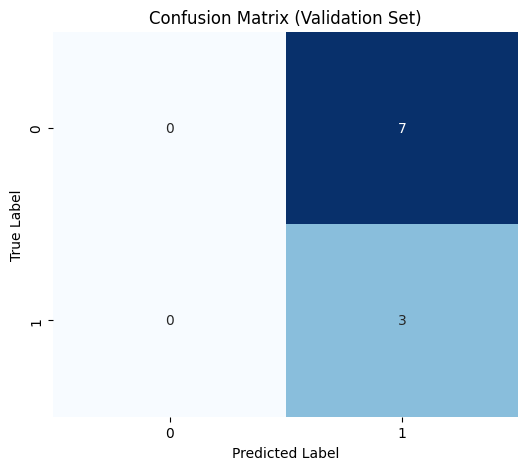

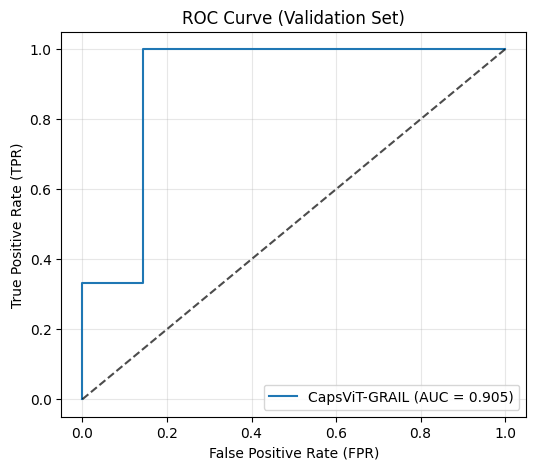

--- End Evaluation ---


In [32]:
# %% [markdown]
# ---
# ## 🧪 **PART 5: Evaluation**
# ---

# %%

# --- Ensure Necessary Variables Exist ---
# These should ideally be available from previous parts

model_ready_for_eval = False
if 'capsvit_grail_model_inst' in locals() and isinstance(capsvit_grail_model_inst, nn.Module):
    model_ready_for_eval = True
else:
    print("Evaluation SKIPPED: Model instance 'capsvit_grail_model_inst' not found or is not a valid nn.Module.")
    
data_loader_ready_for_eval = False
if 'val_loader_final' in locals() and isinstance(val_loader_final, DataLoader) and len(val_loader_final) > 0:
    data_loader_ready_for_eval = True
elif 'val_loader_final' in locals() and isinstance(val_loader_final, DataLoader) and len(val_loader_final) == 0:
     print("Evaluation SKIPPED: Validation DataLoader 'val_loader_final' exists but is empty.")
else:
     print("Evaluation SKIPPED: Validation DataLoader 'val_loader_final' not found or is not a DataLoader.")

# Define/Ensure Criterion Exists (use the correct argument 'num_cls')
if 'combined_criterion_inst' not in locals():
    print("Warning: Criterion 'combined_criterion_inst' not found from training block. Creating a new instance for evaluation.")
    # Ensure decision_final_config is available from Part 3 definition
    if 'decision_final_config' in locals():
         try:
            evaluation_criterion = CombinedLoss(
                 num_cls=decision_final_config['decision_params']['num_decision_classes']
            )
         except NameError: # If CombinedLoss class itself is not defined
             print("ERROR: Cannot create criterion. CombinedLoss class definition not found.")
             evaluation_criterion = None
         except KeyError:
             print("ERROR: Cannot create criterion. decision_final_config structure incorrect.")
             evaluation_criterion = None
    else:
        print("ERROR: Cannot create criterion. 'decision_final_config' not found.")
        evaluation_criterion = None
elif not isinstance(combined_criterion_inst, nn.Module):
     print(f"ERROR: 'combined_criterion_inst' found but is not an nn.Module (type: {type(combined_criterion_inst)}). Cannot use for evaluation.")
     evaluation_criterion = None
else:
     evaluation_criterion = combined_criterion_inst # Use the one from training

criterion_ready_for_eval = evaluation_criterion is not None


# --- Define Evaluation Function ---
def evaluate_model_fn(model_to_eval, loader_eval, criterion_eval, device_eval):
    model_to_eval.eval()
    final_loss_eval = 0.0
    all_preds_probs_eval, all_targets_list_eval = [], []
    eval_batch_count = 0

    with torch.no_grad():
        # Use tqdm for progress if available
        try:
            from tqdm.notebook import tqdm
            eval_iterator = tqdm(loader_eval, desc="Evaluating Batches", leave=False)
        except ImportError:
            eval_iterator = loader_eval

        for vols_e, targs_e in eval_iterator:
            vols_e, targs_e = vols_e.to(device_eval), targs_e.to(device_eval)
            
            # Forward pass
            # Ensure model returns lengths first, then raw capsules
            lens_e, raw_caps_e = model_to_eval(vols_e) 
            
            # Calculate loss
            # Ensure criterion handles raw_caps argument even if unused (use dummy '_' if needed)
            loss_e, _, _ = criterion_eval(lens_e, raw_caps_e, targs_e) 
            final_loss_eval += loss_e.item()
            
            # Store predictions (probabilities) and targets
            all_preds_probs_eval.extend(torch.sigmoid(lens_e.detach()).cpu().numpy())
            all_targets_list_eval.extend(targs_e.cpu().numpy())
            eval_batch_count += 1

    # Check if any batches were processed
    if eval_batch_count == 0:
        print("Warning: Evaluation loop processed 0 batches.")
        # Return default dict indicating failure but with loss 0 instead of NaN
        return {"loss": 0.0, "auc": 0, "f1": 0, "accuracy": 0, "precision": 0, "recall": 0, "conf_matrix": np.zeros((2,2)), "predictions_probs": np.array([]), "targets": np.array([])}

    avg_loss_e = final_loss_eval / eval_batch_count
    
    # Prepare outputs for metrics calculation
    preds_arr_e = np.array(all_preds_probs_eval).squeeze()
    targs_arr_e = np.array(all_targets_list_eval).squeeze()
    
    eval_results_dict = {"loss": avg_loss_e, "auc": 0, "f1": 0, "accuracy": 0, "precision": 0, "recall": 0, "conf_matrix": np.zeros((2,2))}
    eval_results_dict["predictions_probs"] = preds_arr_e # Store arrays even if metrics fail
    eval_results_dict["targets"] = targs_arr_e

    # Check for valid conditions for metric calculations
    if preds_arr_e.size == 0 or targs_arr_e.size == 0 :
        print("Warning: No predictions or targets collected for evaluation metrics.")
        return eval_results_dict # Return dict with loss and empty preds/targets
    if len(np.unique(targs_arr_e)) < 2:
        print("Warning: Only one class present in evaluation targets. AUC/F1 etc. not meaningful.")
        # Calculate accuracy only if possible
        try:
            bin_preds_e_single_class = (preds_arr_e >= 0.5).astype(int)
            eval_results_dict["accuracy"] = accuracy_score(targs_arr_e, bin_preds_e_single_class)
            eval_results_dict["conf_matrix"] = confusion_matrix(targs_arr_e, bin_preds_e_single_class)
        except Exception as e_acc:
            print(f"Error calculating single-class accuracy/CM: {e_acc}")
        return eval_results_dict

    # Calculate full metrics
    try:
        eval_results_dict["auc"] = roc_auc_score(targs_arr_e, preds_arr_e)
        bin_preds_e = (preds_arr_e >= 0.5).astype(int)
        eval_results_dict["accuracy"] = accuracy_score(targs_arr_e, bin_preds_e)
        eval_results_dict["f1"] = f1_score(targs_arr_e, bin_preds_e, zero_division=0)
        eval_results_dict["precision"] = precision_score(targs_arr_e, bin_preds_e, zero_division=0)
        eval_results_dict["recall"] = recall_score(targs_arr_e, bin_preds_e, zero_division=0)
        eval_results_dict["conf_matrix"] = confusion_matrix(targs_arr_e, bin_preds_e)
    except Exception as e_metrics:
         print(f"ERROR calculating evaluation metrics: {e_metrics}")
         # Keep default zero values but return collected loss/preds/targets

    return eval_results_dict

# --- Perform final evaluation ---
final_eval_results = None # Initialize
if model_ready_for_eval and data_loader_ready_for_eval and criterion_ready_for_eval:
    print("\n--- Performing final evaluation on validation set ---")
    
    final_eval_results = evaluate_model_fn(
        capsvit_grail_model_inst, 
        val_loader_final, 
        evaluation_criterion, # Use the verified/created criterion
        DEVICE
    )

    # --- Display Results ---
    print(f"\nValidation Results (Custom Preprocessing):")
    if final_eval_results:
        # Print metrics nicely
        print(f"  Loss: {final_eval_results.get('loss', float('nan')):.4f}")
        print(f"  AUC: {final_eval_results.get('auc', 0.0):.4f}")
        print(f"  F1 Score: {final_eval_results.get('f1', 0.0):.4f}")
        print(f"  Accuracy: {final_eval_results.get('accuracy', 0.0):.4f}")
        print(f"  Precision: {final_eval_results.get('precision', 0.0):.4f}")
        print(f"  Recall: {final_eval_results.get('recall', 0.0):.4f}")
        
        # Plot Confusion Matrix
        cm = final_eval_results.get('conf_matrix')
        if cm is not None and isinstance(cm, np.ndarray) and cm.size > 0:
            try:
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title('Confusion Matrix (Validation Set)')
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.show()
            except Exception as e_plot_cm:
                 print(f"Error plotting confusion matrix: {e_plot_cm}")
        else:
            print("  Confusion Matrix not available or invalid.")

        # Plot ROC Curve if AUC > 0 (meaning calculation was likely valid)
        targets_roc = final_eval_results.get('targets')
        preds_roc = final_eval_results.get('predictions_probs')
        auc_roc = final_eval_results.get('auc', 0)
        if auc_roc > 0 and targets_roc is not None and preds_roc is not None and len(np.unique(targets_roc)) > 1 :
             try:
                 fpr, tpr, _ = roc_curve(targets_roc, preds_roc)
                 plt.figure(figsize=(6, 5))
                 plt.plot(fpr, tpr, label=f"CapsViT-GRAIL (AUC = {auc_roc:.3f})")
                 plt.plot([0, 1], [0, 1], 'k--', alpha=0.7) # Random chance line
                 plt.xlabel('False Positive Rate (FPR)')
                 plt.ylabel('True Positive Rate (TPR)')
                 plt.title('ROC Curve (Validation Set)')
                 plt.legend()
                 plt.grid(True, alpha=0.3)
                 plt.show()
             except Exception as e_plot_roc:
                  print(f"Error plotting ROC curve: {e_plot_roc}")
        elif auc_roc == 0:
             print("  ROC curve not plotted (AUC is 0, likely due to single class or calculation error).")
        else:
             print("  ROC curve not plotted (missing prediction/target data).")
             
    else: # Should not happen if evaluate_model_fn always returns dict
        print("  Evaluation function returned None unexpectedly.")
        
else:
    print("\nSkipping final evaluation: One or more prerequisites (Model, DataLoader, Criterion) not met.")

print("--- End Evaluation ---")

Generating placeholder visualizations for patient 1bb17a55702a78142cd05cd1063c82c8...


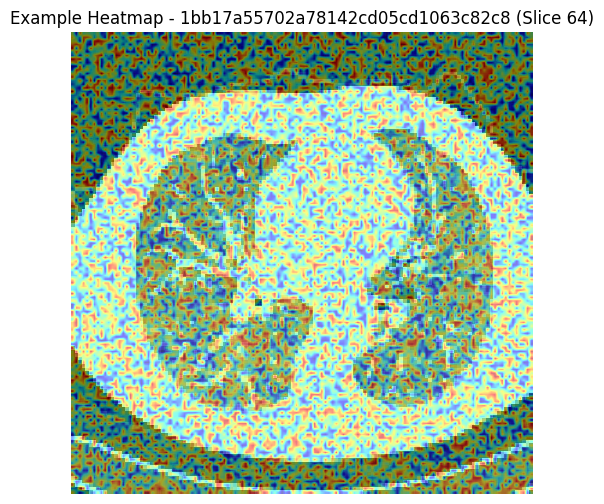

ReportLab not found. PDF report generation will be skipped.
CapsViT-GRAIL Research Notebook (Custom Preprocessing) execution complete.


In [31]:

# ## 📜 **PART 6: Final Report Generation (Conceptual)**
# ---
# (This part remains structurally similar: visualize_model_interpretations, generate_pdf_report, markdown table)

# %%
# visualize_model_interpretations (definition remains the same)
# generate_pdf_report (definition remains the same, uses reportlab)
# Markdown table for comparison (remains the same)
# ... (Full definitions for these would be here) ...
def plot_volume_slice_with_heatmap(volume_slice_2d, heatmap_slice_2d, title_str="Slice with Heatmap", alpha_val=0.5, cmap_img='gray', cmap_heat='jet'):
    plt.imshow(volume_slice_2d, cmap=cmap_img); plt.imshow(heatmap_slice_2d, cmap=cmap_heat, alpha=alpha_val, interpolation='bilinear')
    plt.title(title_str); plt.axis('off');

def visualize_model_interpretations_placeholder(model_viz, volume_tensor_bcdhw, patient_id_viz, config_viz, slice_idx_d=None):
    model_viz.eval()
    print(f"Generating placeholder visualizations for patient {patient_id_viz}...")
    if slice_idx_d is None: slice_idx_d = volume_tensor_bcdhw.shape[2] // 2 # Middle depth slice
    
    # For actual interpretations, one would implement GradCAM or use attention maps from the model.
    # Here, just show the input slice and a random heatmap as a placeholder.
    input_slice_hw = volume_tensor_bcdhw[0, 0, slice_idx_d, :, :].cpu().numpy()
    dummy_heatmap_hw = np.random.rand(input_slice_hw.shape[0], input_slice_hw.shape[1])
    
    plt.figure(figsize=(6,6))
    plot_volume_slice_with_heatmap(input_slice_hw, dummy_heatmap_hw, title_str=f"Example Heatmap - {patient_id_viz} (Slice {slice_idx_d})")
    plt.savefig(os.path.join(config_viz["results_path"], f"heatmap_placeholder_{patient_id_viz}.png"))
    plt.show(); plt.close()

if val_dataset_ft and len(val_dataset_ft) > 0 and capsvit_grail_model_inst:
    vis_sample_vol, _ = val_dataset_ft[0]
    vis_sample_id = val_dataset_ft.patient_ids[0]
    visualize_model_interpretations_placeholder(capsvit_grail_model_inst, vis_sample_vol.unsqueeze(0).to(DEVICE), vis_sample_id, CONFIG)
# else: print("Skipping interpretation visualization example.")

# PDF Generation (using ReportLab - conceptual, ensure reportlab is installed)
try:
    from reportlab.lib.pagesizes import letter
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer, Table, TableStyle
    from reportlab.lib.styles import getSampleStyleSheet
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    REPORTLAB_AVAILABLE = True
except ImportError:
    REPORTLAB_AVAILABLE = False; print("ReportLab not found. PDF report generation will be skipped.")

def generate_custom_pdf_report(config_pdf, eval_res_dict):
    # ... (definition as in original notebook, ensure image paths are correct) ...
    if not REPORTLAB_AVAILABLE or eval_res_dict is None: return
    report_filename = os.path.join(config_pdf["results_path"], "CapsViT_GRAIL_Report_CustomPrep.pdf")
    doc = SimpleDocTemplate(report_filename, pagesize=letter); styles = getSampleStyleSheet(); story = []
    story.append(Paragraph("CapsViT-GRAIL Performance Report (Custom Preprocessing)", styles['h1'])); story.append(Spacer(1, 0.2*inch))
    story.append(Paragraph("Summary Metrics:", styles['h2']))
    metrics_list_data = [["Metric", "Value"]] + [[k.capitalize(), f"{v:.4f}"] for k,v in eval_res_dict.items() if isinstance(v, (int, float)) and k != "loss"]
    metrics_tbl = Table(metrics_list_data); metrics_tbl.setStyle(TableStyle([('BACKGROUND',(0,0),(-1,0),colors.grey),('TEXTCOLOR',(0,0),(-1,0),colors.whitesmoke),('ALIGN',(0,0),(-1,-1),'CENTER'),('GRID',(0,0),(-1,-1),1,colors.black)])); story.append(metrics_tbl); story.append(Spacer(1,0.2*inch))
    # Add CM, ROC, Heatmap images (ensure paths are correct and files exist)
    # ... (add logic to find and include images similar to original notebook) ...
    doc.build(story); print(f"PDF report generated: {report_filename}")

if final_eval_results: generate_custom_pdf_report(CONFIG, final_eval_results)

# %% [markdown]
# ### Comparative Summary Table (Markdown)
# ... (Markdown table as in original notebook) ...
#
# ---
# ## ✨ **Conclusion and Future Work**
# ---
# ... (Conclusion as in original notebook, potentially updated based on custom preprocessing experience) ...

# %%
print("CapsViT-GRAIL Research Notebook (Custom Preprocessing) execution complete.")